# 3. Classification

---

### Setup

In [1]:
import sys
sys.path.insert(1, '../utils')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
from sklearn.model_selection import StratifiedKFold

data: pd.DataFrame = pd.read_csv('heart_failure_clinical_records_dataset_after_preparation_balanced.csv', sep=';')

## 3.0. Training Models

---

### Training Models

---

#### StratifiedKFold function
After loading the data, in data dataframe, we need to separate the target variable which is the DEATH_EVENT from the rest of the data, since it plays a different role in the training procedure. Through the application of the pop method, we get the class variable, and simultaneously removing it from the dataframe. So, y will keep the ndarray with the target variable for each record and X the ndarray containing the records themselves

In [2]:
target = 'DEATH_EVENT'
positive = True
negative = False
values = {'Original': [len(data[data[target] == positive]), len(data[data[target] == negative])]}

y: np.ndarray = data.pop(target).values
X: np.ndarray = data.values
labels: np.ndarray = pd.unique(y)

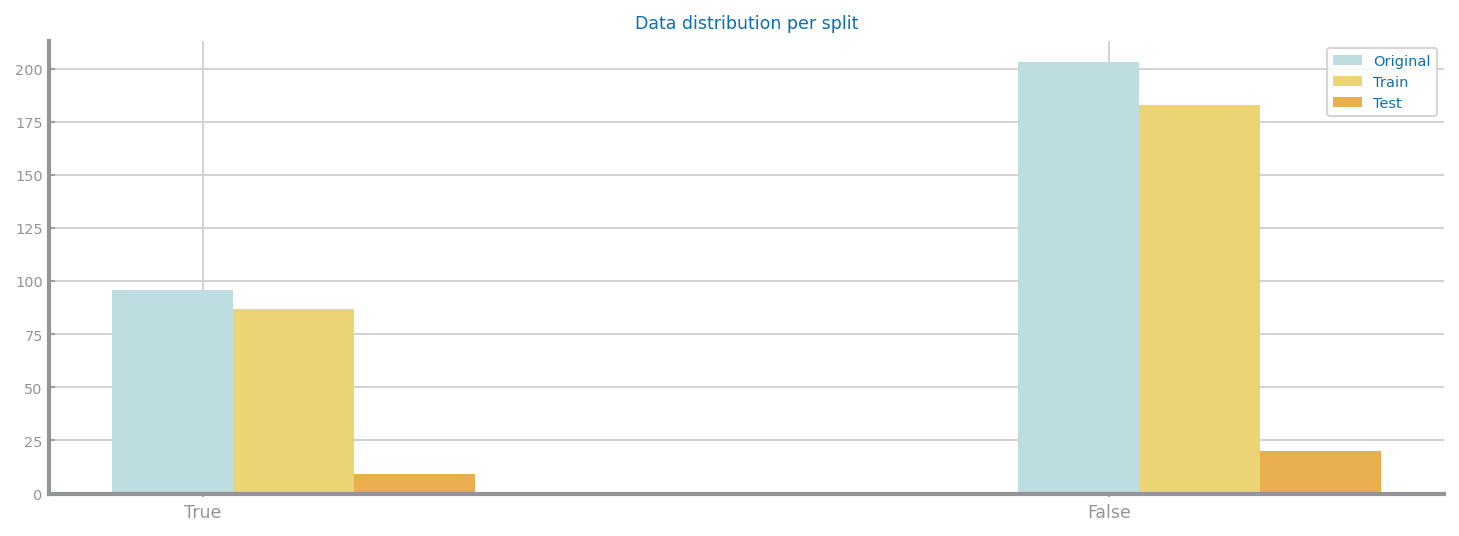

In [3]:
np.random.seed(1)
skf = StratifiedKFold(n_splits=10, shuffle=True)
skf.get_n_splits(X, y)

splits=[]

for train_index, test_index in skf.split(X, y):
    splits.append({'X_train': X[train_index], 'X_test': X[test_index],
                  'y_train': y[train_index], 'y_test': y[test_index]})

values['Train'] = [len(np.delete(y[train_index], np.argwhere(y[train_index]==negative))), len(np.delete(y[train_index], np.argwhere(y[train_index]==positive)))]
values['Test'] = [len(np.delete(y[test_index], np.argwhere(y[test_index]==negative))), len(np.delete(y[test_index], np.argwhere(y[test_index]==positive)))]

plt.figure(figsize=(12,4))
ds.multiple_bar_chart([positive, negative], values, title='Data distribution per split', showXTickLabels=True)
plt.show()

We have just plotted the chart of one split because the splits have identical distribution which will make the bar charts equal.

### Evaluation

---

#### Accuracy
The simplest measure is accuracy, which reports the percentage of correct predictions. It is just the opposite of error. In sklearn, accuracy is reported through the score method from each classifier, after its training and measured over a particular dataset and its known labels.

In [4]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
for split in splits:
    clf.fit(split['X_train'], split['y_train'])
    print(clf.score(split['X_test'], split['y_test']))

0.7
0.7
0.6666666666666666
0.8333333333333334
0.8
0.7333333333333333
0.8
0.7666666666666667
0.8333333333333334
0.7931034482758621


In our example we can see that naive Bayes is better with some splits than others.

#### Confusion Matrix
The simplest measure is accuracy, which reports the percentage of correct predictions. It is just the opposite of error. In sklearn, accuracy is reported through the score method from each classifier, after its training and measured over a particular dataset and its known labels.

In [5]:
import sklearn.metrics as metrics

labels: np.ndarray = [False, True]
    
total_mtx = np.zeros((2, 2), dtype='i')
total_acc = 0
    
for split in splits:
    prdY: np.ndarray = clf.predict(split['X_test'])
    cnf_mtx: np.ndarray = metrics.confusion_matrix(split['y_test'], prdY, labels)
    split['prdY'] = prdY
    split['cnf_mtx'] = cnf_mtx
    total_mtx += cnf_mtx
    total_acc += sum(cnf_mtx[0]) / sum(cnf_mtx[0] + cnf_mtx[1])

print(total_mtx)
print('Accuracy if it classifies everything as negative:\n', total_acc / len(splits))

[[187  16]
 [ 53  43]]
Accuracy if it classifies everything as negative:
 0.6789655172413793


<Figure size 600x450 with 0 Axes>

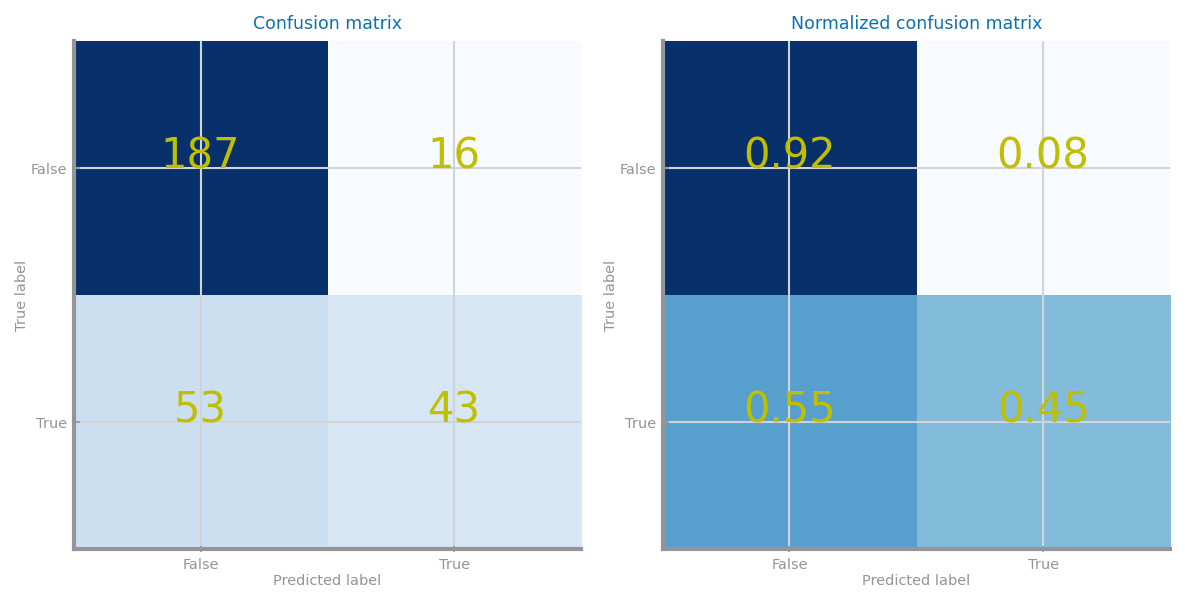

In [6]:
import itertools
import matplotlib.pyplot as plt
CMAP = plt.cm.Blues

def plot_confusion_matrix(cnf_matrix: np.ndarray, classes_names: np.ndarray, ax: plt.Axes = None,
                          normalize: bool = False):
    if ax is None:
        ax = plt.gca()
    if normalize:
        total = cnf_matrix.sum(axis=1)[:, np.newaxis]
        cm = cnf_matrix.astype('float') / total
        title = "Normalized confusion matrix"
    else:
        cm = cnf_matrix
        title = 'Confusion matrix'
    np.set_printoptions(precision=2)
    tick_marks = np.arange(0, len(classes_names), 1)
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes_names)
    ax.set_yticklabels(classes_names)
    ax.imshow(cm, interpolation='nearest', cmap=CMAP)

    fmt = '.2f' if normalize else 'd'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt), color='y', horizontalalignment="center", size=20)

plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(8, 4), squeeze=False)
plot_confusion_matrix(total_mtx, labels, ax=axs[0,0])
plot_confusion_matrix(total_mtx, labels, axs[0,1], normalize=True)
plt.tight_layout()
plt.show()

#### Classification metrics

In [7]:
totalYTest = np.array(())
totalPrdY = np.array(())
for split in splits:
    totalYTest = np.concatenate((totalYTest, split['y_test']))
    totalPrdY = np.concatenate((totalPrdY, split['prdY']))

print('Recall Score: ', metrics.recall_score(totalYTest, totalPrdY))
print('Precision Score: ', metrics.precision_score(totalYTest, totalPrdY))
print('F1 Score: ', metrics.f1_score(totalYTest, totalPrdY))
print('Balanced Accuracy Score: ', metrics.balanced_accuracy_score(totalYTest, totalPrdY))

Recall Score:  0.4479166666666667
Precision Score:  0.7288135593220338
F1 Score:  0.5548387096774193
Balanced Accuracy Score:  0.6845494663382594


## 3.1. Naive Bayes

---

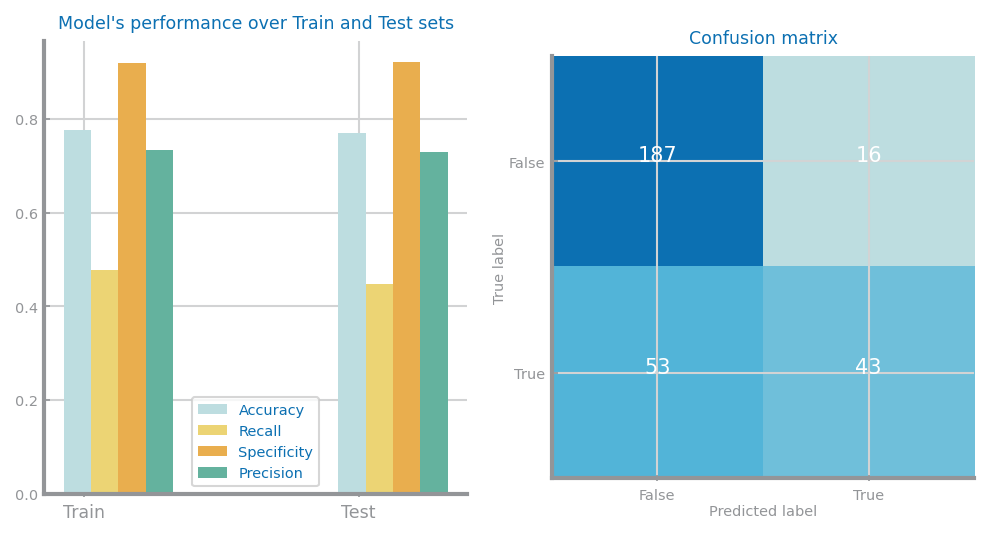

In [8]:
import sklearn.metrics as metrics
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

totalYTrn = np.array(())
totalPrd_trn = np.array(())

for split in splits:
    clf.fit(split['X_train'], split['y_train'])
    prd_trn = clf.predict(split['X_train'])
    totalYTrn = np.concatenate((totalYTrn, split['y_train']))
    totalPrd_trn = np.concatenate((totalPrd_trn, prd_trn))
    
ds.plot_evaluation_results(labels, totalYTrn, totalPrd_trn, totalYTest, totalPrdY, showXTickLabels=True)

[0.7626436781609195, 0.6924137931034482, 0.6789655172413793]


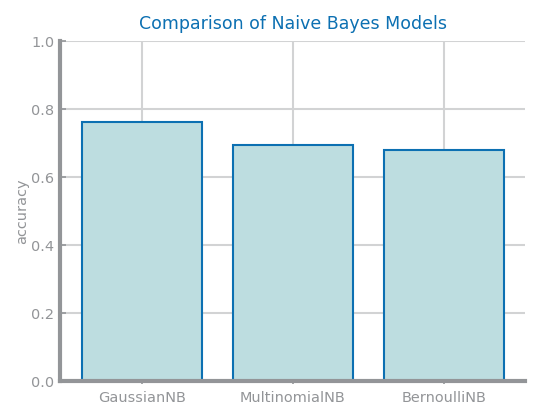

In [9]:
estimators = {'GaussianNB': GaussianNB(),
              'MultinomialNB': MultinomialNB(),
              'BernoulliNB': BernoulliNB()}

xvalues = [est for est in estimators]
yvalues = [0 for _ in estimators]

for split in splits:
    for i in range(len(xvalues)):
        clf = xvalues[i]
        estimators[clf].fit(split['X_train'], split['y_train'])
        prdY = estimators[clf].predict(split['X_test'])
        yvalues[i] += metrics.accuracy_score(split['y_test'], prdY)

for i in range(len(yvalues)):
    yvalues[i] /= len(splits)

print(yvalues)
plt.figure()
ds.bar_chart(xvalues, yvalues, title='Comparison of Naive Bayes Models', ylabel='accuracy', percentage=True)
plt.show()

### Summary

---

***Which distribution is more adequate to model our data?***

For most of the splits, the Gaussian distribution models better our data.

***Is the accuracy achieved good enough?***

The accuracy is better than the one of the classifier that considers every record is negative. However, this doesn't mean the classifier is good enough. We still consider it is not very good.

***What is the largest kind of errors?***

False negatives.

## 3.2. KNN

---

### No balancing

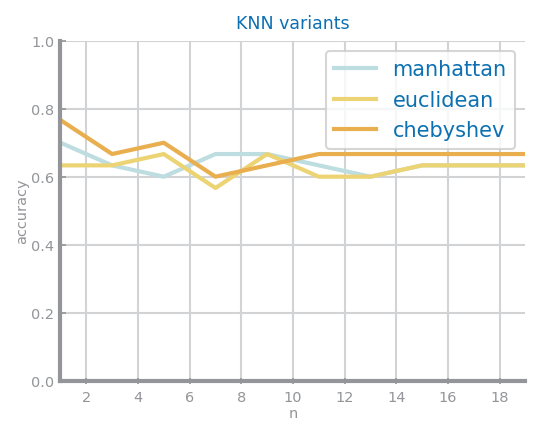

Best accuracy: 0.7666666666666667
Best results with 1 neighbors and chebyshev


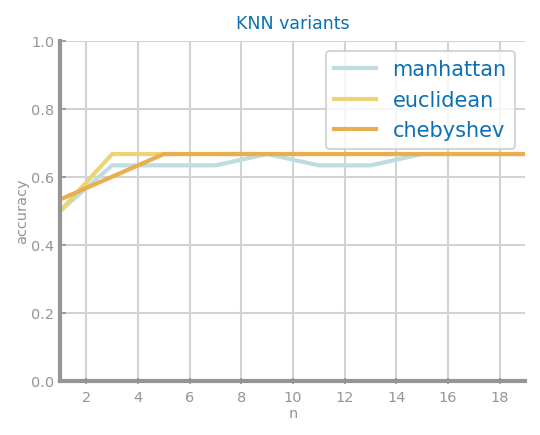

Best accuracy: 0.6666666666666666
Best results with 9 neighbors and manhattan


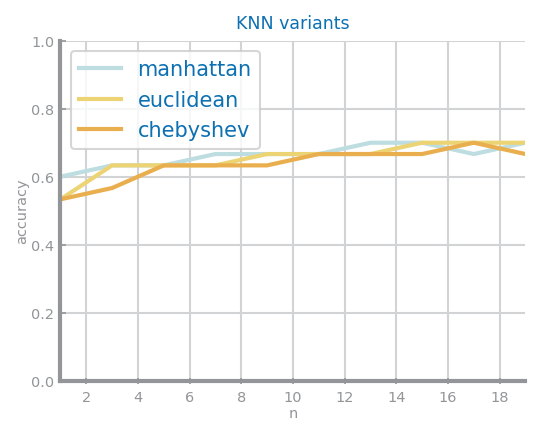

Best accuracy: 0.7
Best results with 13 neighbors and manhattan


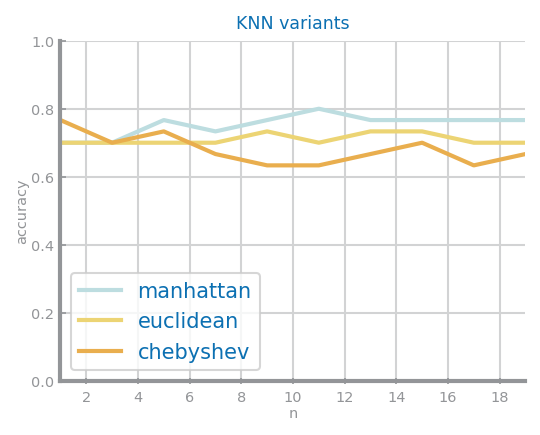

Best accuracy: 0.8
Best results with 11 neighbors and manhattan


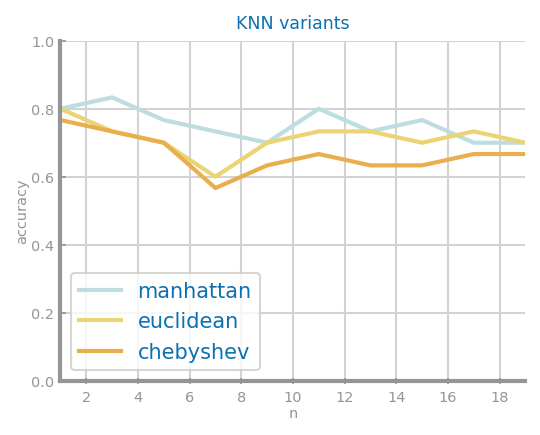

Best accuracy: 0.8333333333333334
Best results with 3 neighbors and manhattan


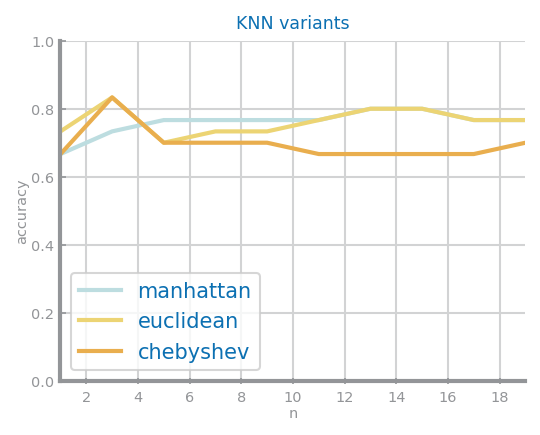

Best accuracy: 0.8333333333333334
Best results with 3 neighbors and euclidean


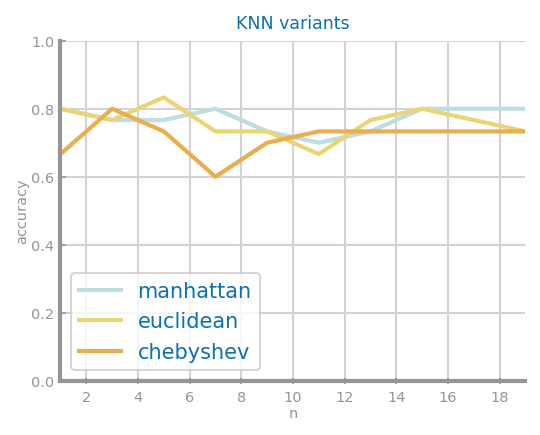

Best accuracy: 0.8333333333333334
Best results with 5 neighbors and euclidean


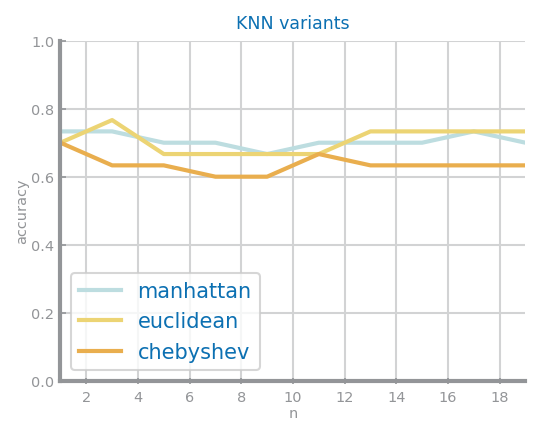

Best accuracy: 0.7666666666666667
Best results with 3 neighbors and euclidean


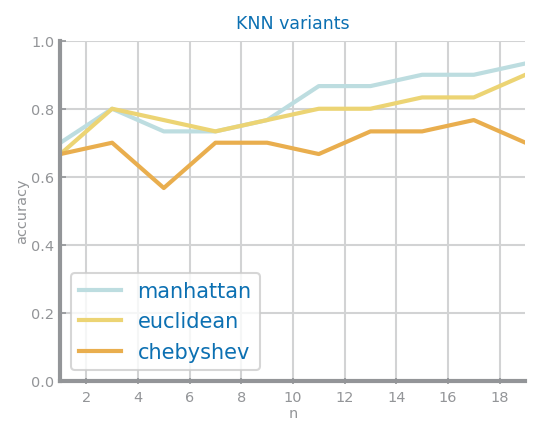

Best accuracy: 0.9333333333333333
Best results with 19 neighbors and manhattan


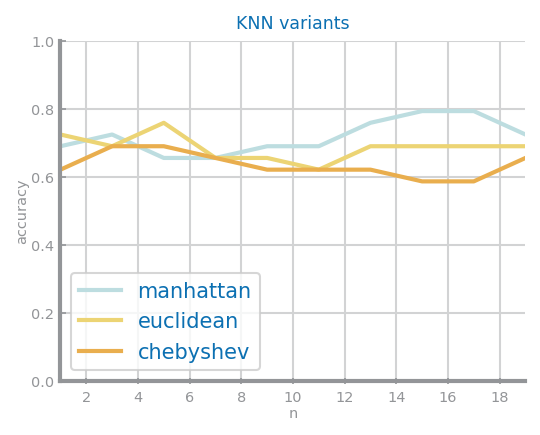

Best accuracy: 0.7931034482758621
Best results with 15 neighbors and manhattan


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsClassifier
import ds_functions as ds

split_best = []

for spli in range(len(splits)):
    split = splits[spli]
    nvalues = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
    dist = ['manhattan', 'euclidean', 'chebyshev']
    values = {}
    best = (0, '')
    last_best = 0
    for d in dist:
        yvalues = []
        for n in nvalues:
            knn = KNeighborsClassifier(n_neighbors=n, metric=d)
            knn.fit(split['X_train'], split['y_train'])
            prdY = knn.predict(split['X_test'])
            yvalues.append(metrics.accuracy_score(split['y_test'], prdY))
            if yvalues[-1] > last_best:
                best = (n, d)
                last_best = yvalues[-1]
        values[d] = yvalues
    split_best.append(best)
    
    plt.figure()
    ds.multiple_line_chart(nvalues, values, title='KNN variants', xlabel='n', ylabel='accuracy', percentage=True)
    plt.show()
    print("Best accuracy:", last_best)
    print('Best results with %d neighbors and %s'%(best[0], best[1]))

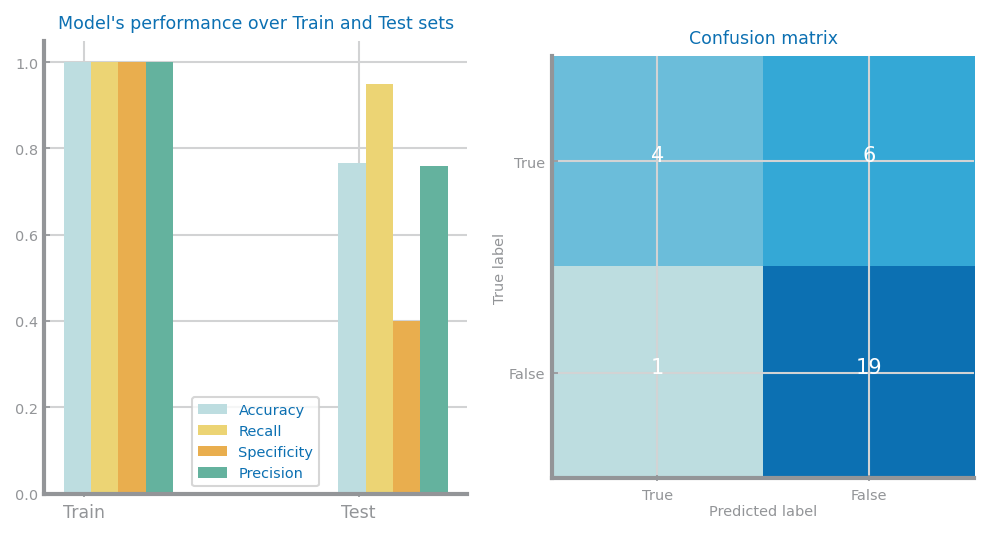

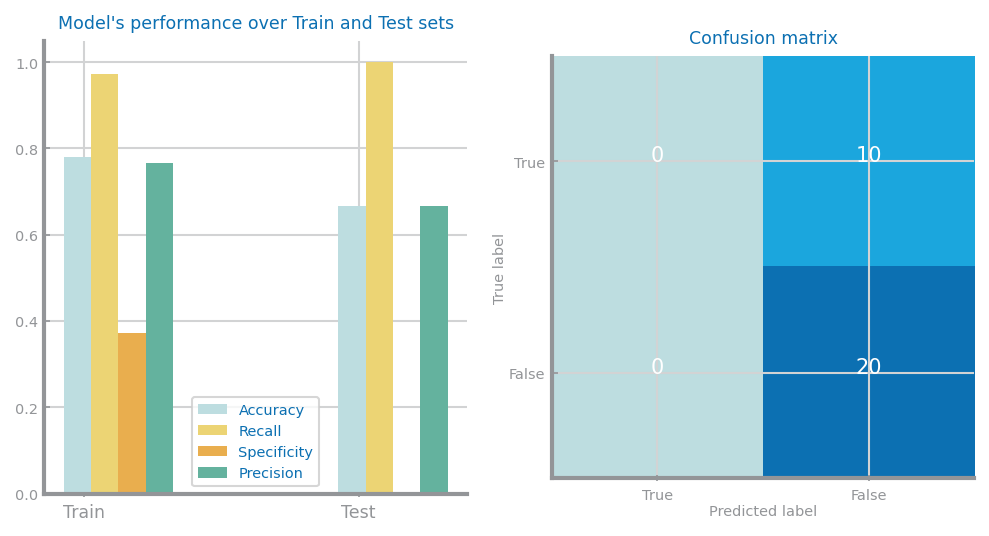

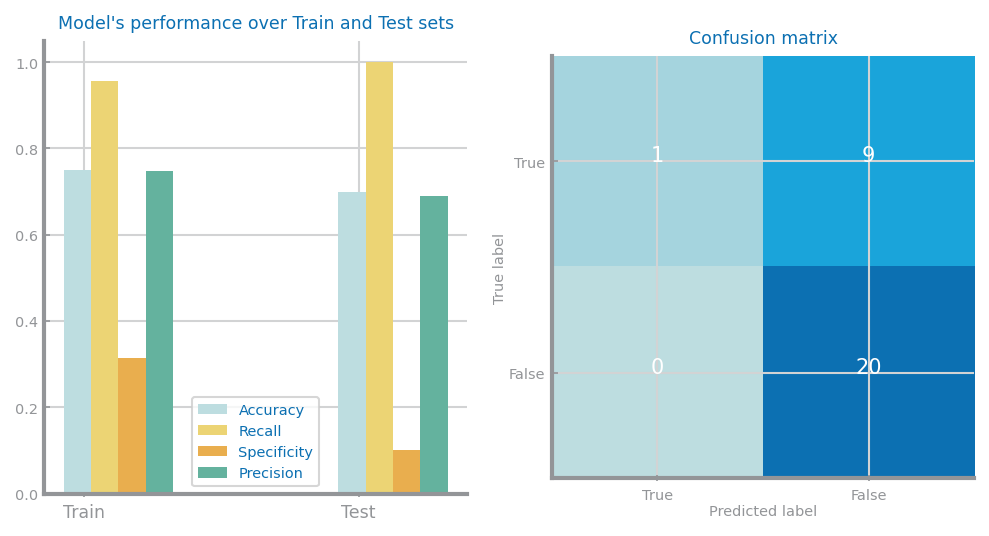

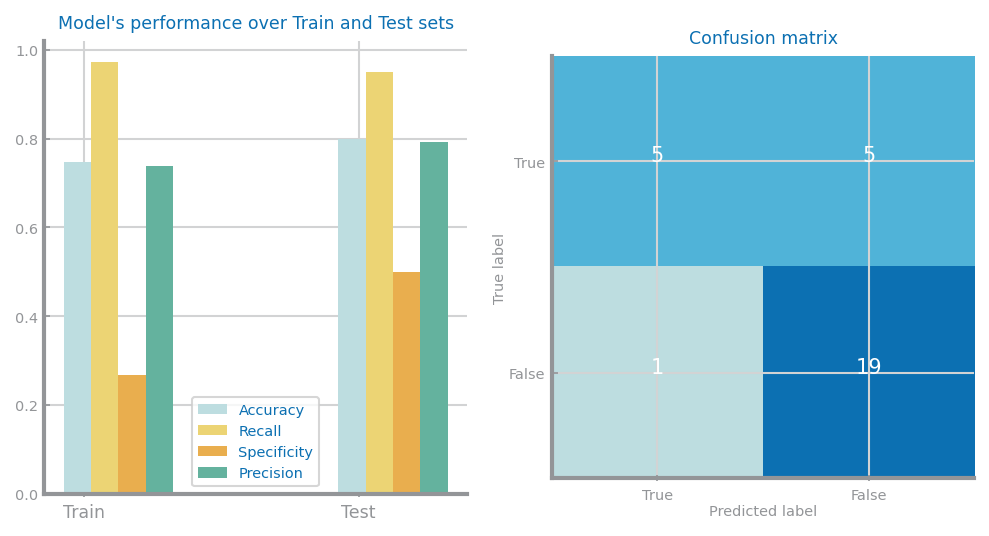

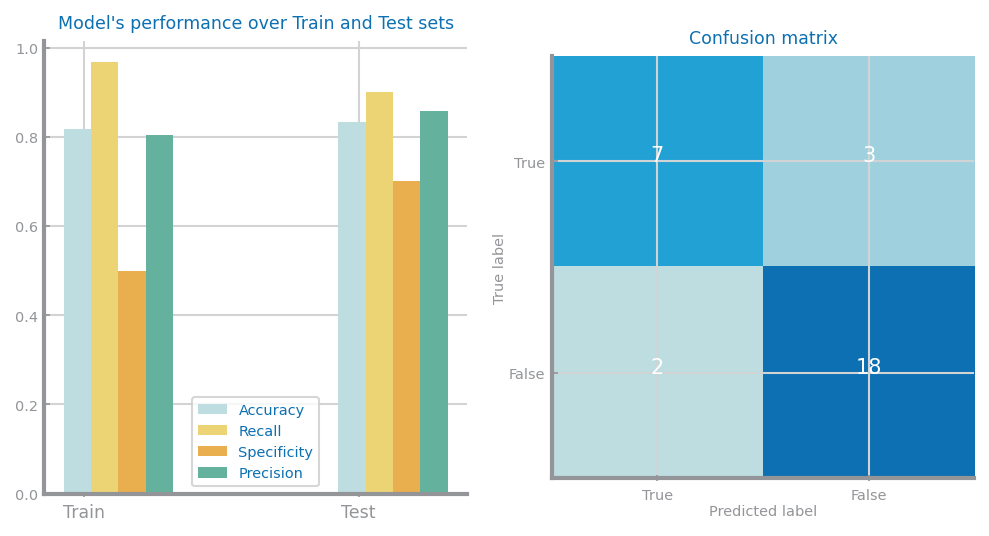

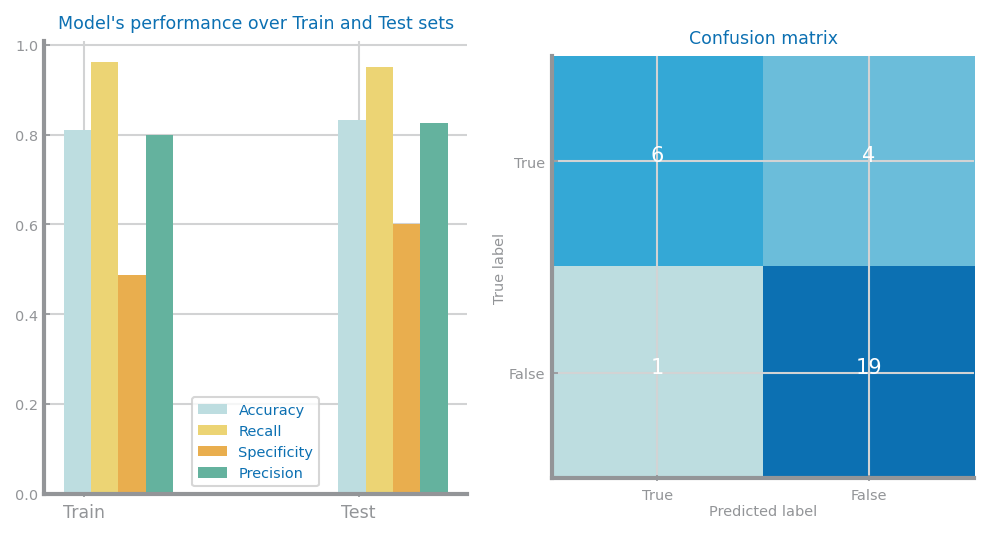

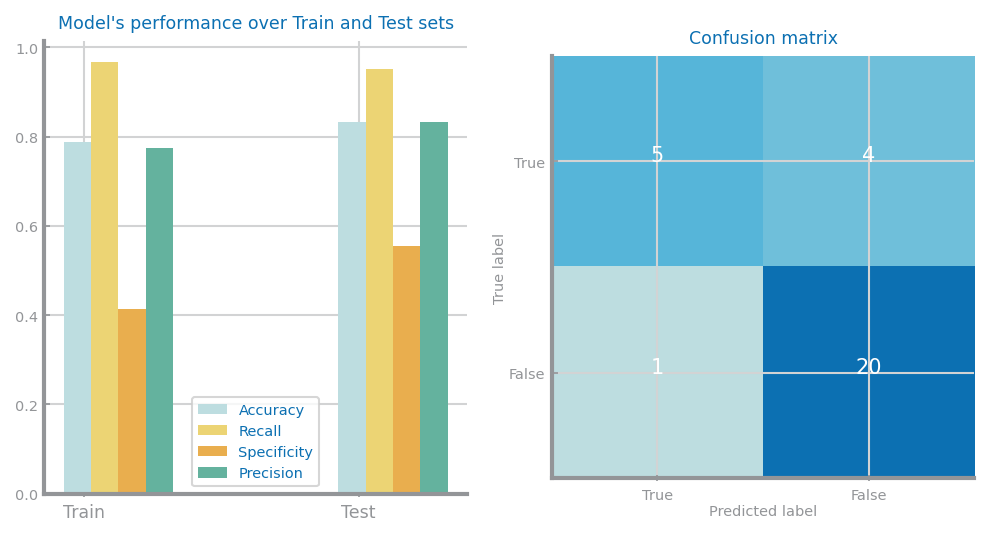

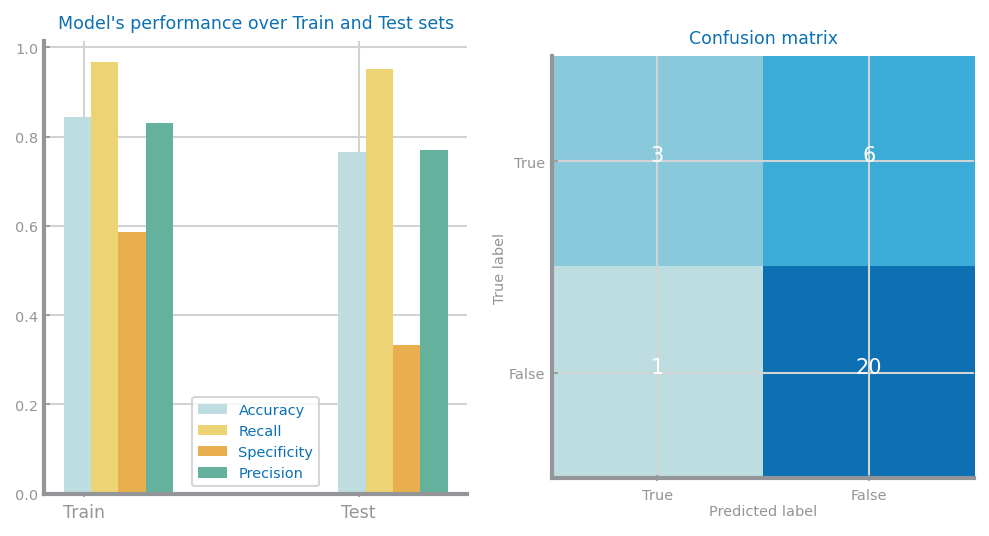

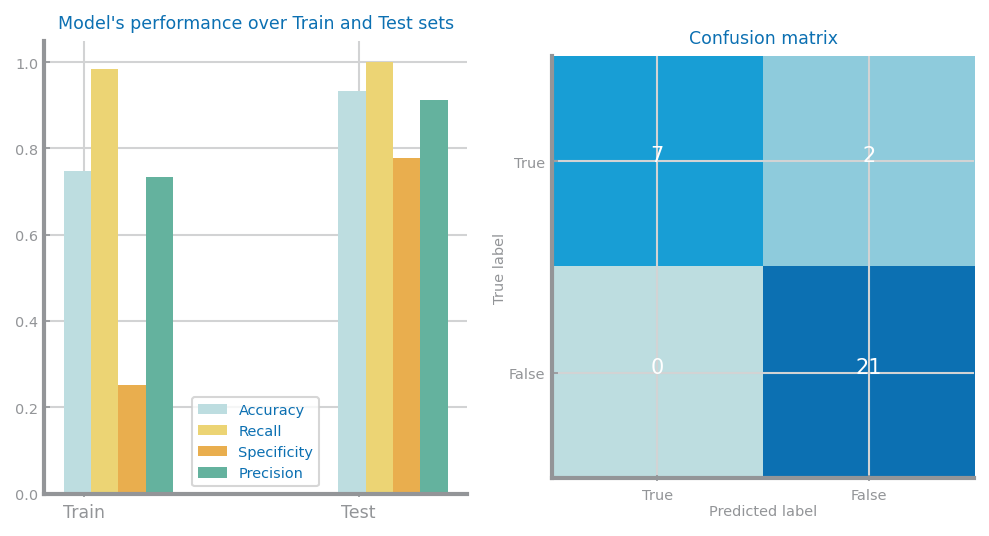

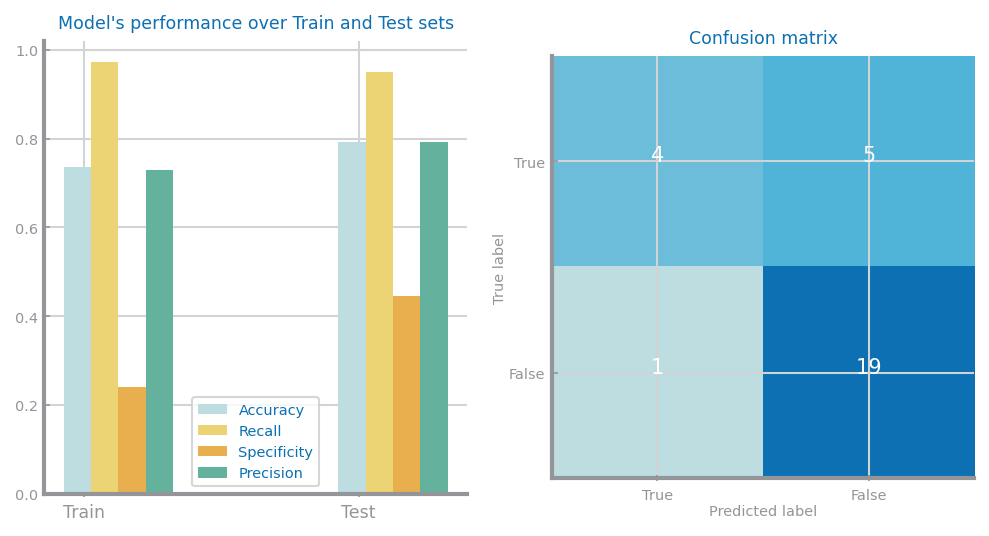

In [11]:
for spli in range(len(splits)):
    split = splits[spli]
    best = split_best[spli]
    clf = KNeighborsClassifier(n_neighbors=best[0], metric=best[1])
    clf.fit(split['X_train'], split['y_train'])
    prd_trn = clf.predict(split['X_train'])
    prd_tst = clf.predict(split['X_test'])
    ds.plot_evaluation_results([True, False], split['y_train'], prd_trn, split['y_test'], prd_tst, showXTickLabels=True)

### Summary

---

***How do models improve with the increase of neighbors?***

The impact of the number of neighbors in the in the results seems to depend on the split between train and test records. We could not reach any conclusion.

***How does performance changes with different distance measures?***

The Chebyshev measure doens't seem very appropriate for this dataset. It is almost always worse or similar to the other 2 in terms of performance (accuracy).
Manhattan and Euclidean measures are similar.

***What is the best parametrisation (number of neighbors and distance measure)?***

The best results (~0.833 accuracy) were shared between 3 of the splits. The number of neighbors was different on each of the parametrisations with the manhattan measure. With the euclidean measure, having 13 as the number of neighbours seemed to yield best results.

***Is the accuracy achieved good enough?***

The accuracy is better than the one of the classifier that considers every record is negative. However, this doesn't mean the classifier is good enough. We still consider it is not very good.

***What is the largest kind of errors?***

False negative.

***Is it possible to identify overfitting?***

In some of the splits, the model seems more adequate for the training set than for the test set. In others, it's the other way around. But the differences were not very significant, so we don't think it is possible to identify overfitting.

## 3.3. Decision Trees

---

<Figure size 600x450 with 0 Axes>

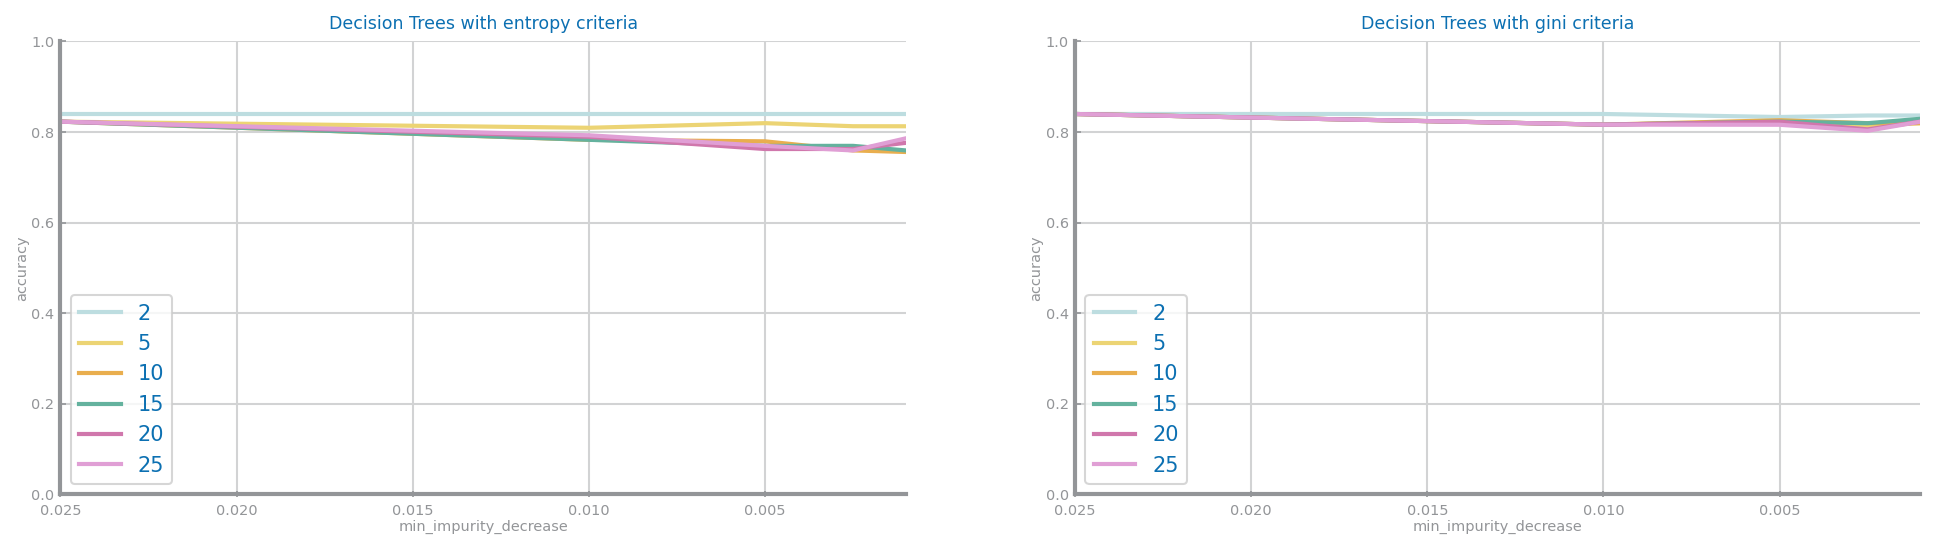

Best results achieved in split 8 with gini criteria, depth=10 and min_impurity_decrease=0.001000 ==> accuracy=1.000000
Best results per split:
	Split 0: entropy criteria, depth=5 and min_impurity_decrease=0.010000 ==> accuracy=0.766667
	Split 1: gini criteria, depth=10 and min_impurity_decrease=0.005000 ==> accuracy=0.766667
	Split 2: entropy criteria, depth=2 and min_impurity_decrease=0.025000 ==> accuracy=0.800000
	Split 3: entropy criteria, depth=2 and min_impurity_decrease=0.025000 ==> accuracy=0.933333
	Split 4: entropy criteria, depth=2 and min_impurity_decrease=0.025000 ==> accuracy=0.900000
	Split 5: entropy criteria, depth=5 and min_impurity_decrease=0.010000 ==> accuracy=0.933333
	Split 6: gini criteria, depth=10 and min_impurity_decrease=0.005000 ==> accuracy=0.866667
	Split 7: entropy criteria, depth=2 and min_impurity_decrease=0.025000 ==> accuracy=0.833333
	Split 8: gini criteria, depth=10 and min_impurity_decrease=0.001000 ==> accuracy=1.000000
	Split 9: entropy criteria

In [12]:
from sklearn.tree import DecisionTreeClassifier

min_impurity_decrease = [0.025, 0.01, 0.005, 0.0025, 0.001]
max_depths = [2, 5, 10, 15, 20, 25]
criteria = ['entropy', 'gini']

best = ('',  0, 0.0) # (criteria, max depth, min impurity decrease)
best_tree = None
last_best = 0 # accuracy
best_split = None
best_spli = 0

NUM_SPLITS = len(splits)
split_best = [('',  0, 0.0)] * NUM_SPLITS
split_best_tree = [None] * NUM_SPLITS
split_last_best = [0] * NUM_SPLITS

plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(16, 4), squeeze=False)
for k in range(len(criteria)):
    f = criteria[k]
    values = {}
    for d in max_depths:
        values[d] = []
        for i in range(len(min_impurity_decrease)):
            values[d].append(0)
    for spli in range(NUM_SPLITS):
        split = splits[spli]
        for d in max_depths:
            yvalues = []
            for imp in min_impurity_decrease:
                tree = DecisionTreeClassifier(max_depth=d, criterion=f, min_impurity_decrease=imp)
                tree.fit(split['X_train'], split['y_train'])
                split['prdY'] = tree.predict(split['X_test'])
                yvalues.append(metrics.accuracy_score(split['y_test'], split['prdY']))
                # Check if accuracy is better than best overall
                if yvalues[-1] > last_best:
                    best = (f, d, imp)
                    last_best = yvalues[-1]
                    best_tree = tree
                    best_split = split
                    best_spli = spli
                # Check if accuracy is better than best in current split
                if yvalues[-1] > split_last_best[spli]:
                    split_best[spli] = (f, d, imp)
                    split_last_best[spli] = yvalues[-1]
                    split_best_tree[spli] = tree
            # Increment total accuracy for current (max_depth, min_impurity decrease)
            for i in range(len(yvalues)):
                values[d][i] += yvalues[i]
    # Normalize
    for v in values:
        for i in range(len(values[v])):
            values[v][i] /= NUM_SPLITS
            
    ds.multiple_line_chart(min_impurity_decrease, values, ax=axs[0, k], title='Decision Trees with %s criteria'%f,
                           xlabel='min_impurity_decrease', ylabel='accuracy', percentage=True)
plt.show()
print('Best results achieved in split %d with %s criteria, depth=%d and min_impurity_decrease=%f ==> accuracy=%f'%(best_spli, best[0], best[1], best[2], last_best))

print('Best results per split:')
for i in range(len(splits)):
    print('\tSplit %d: %s criteria, depth=%d and min_impurity_decrease=%f ==> accuracy=%f' % (i, *split_best[i], split_last_best[i]))

Split 0


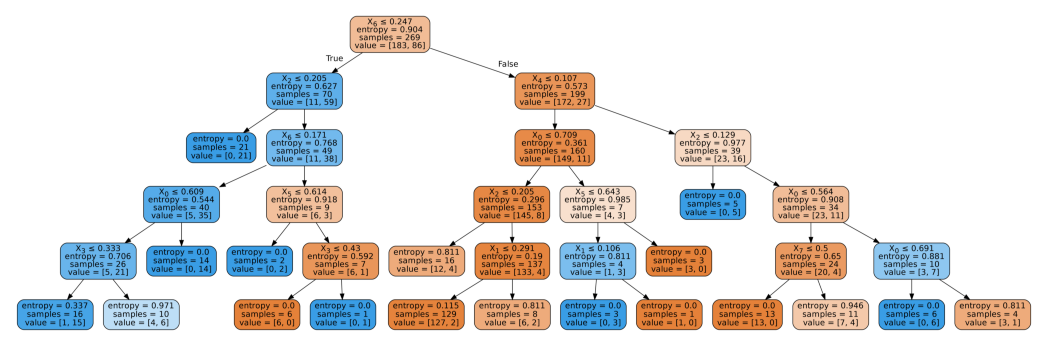

Split 1


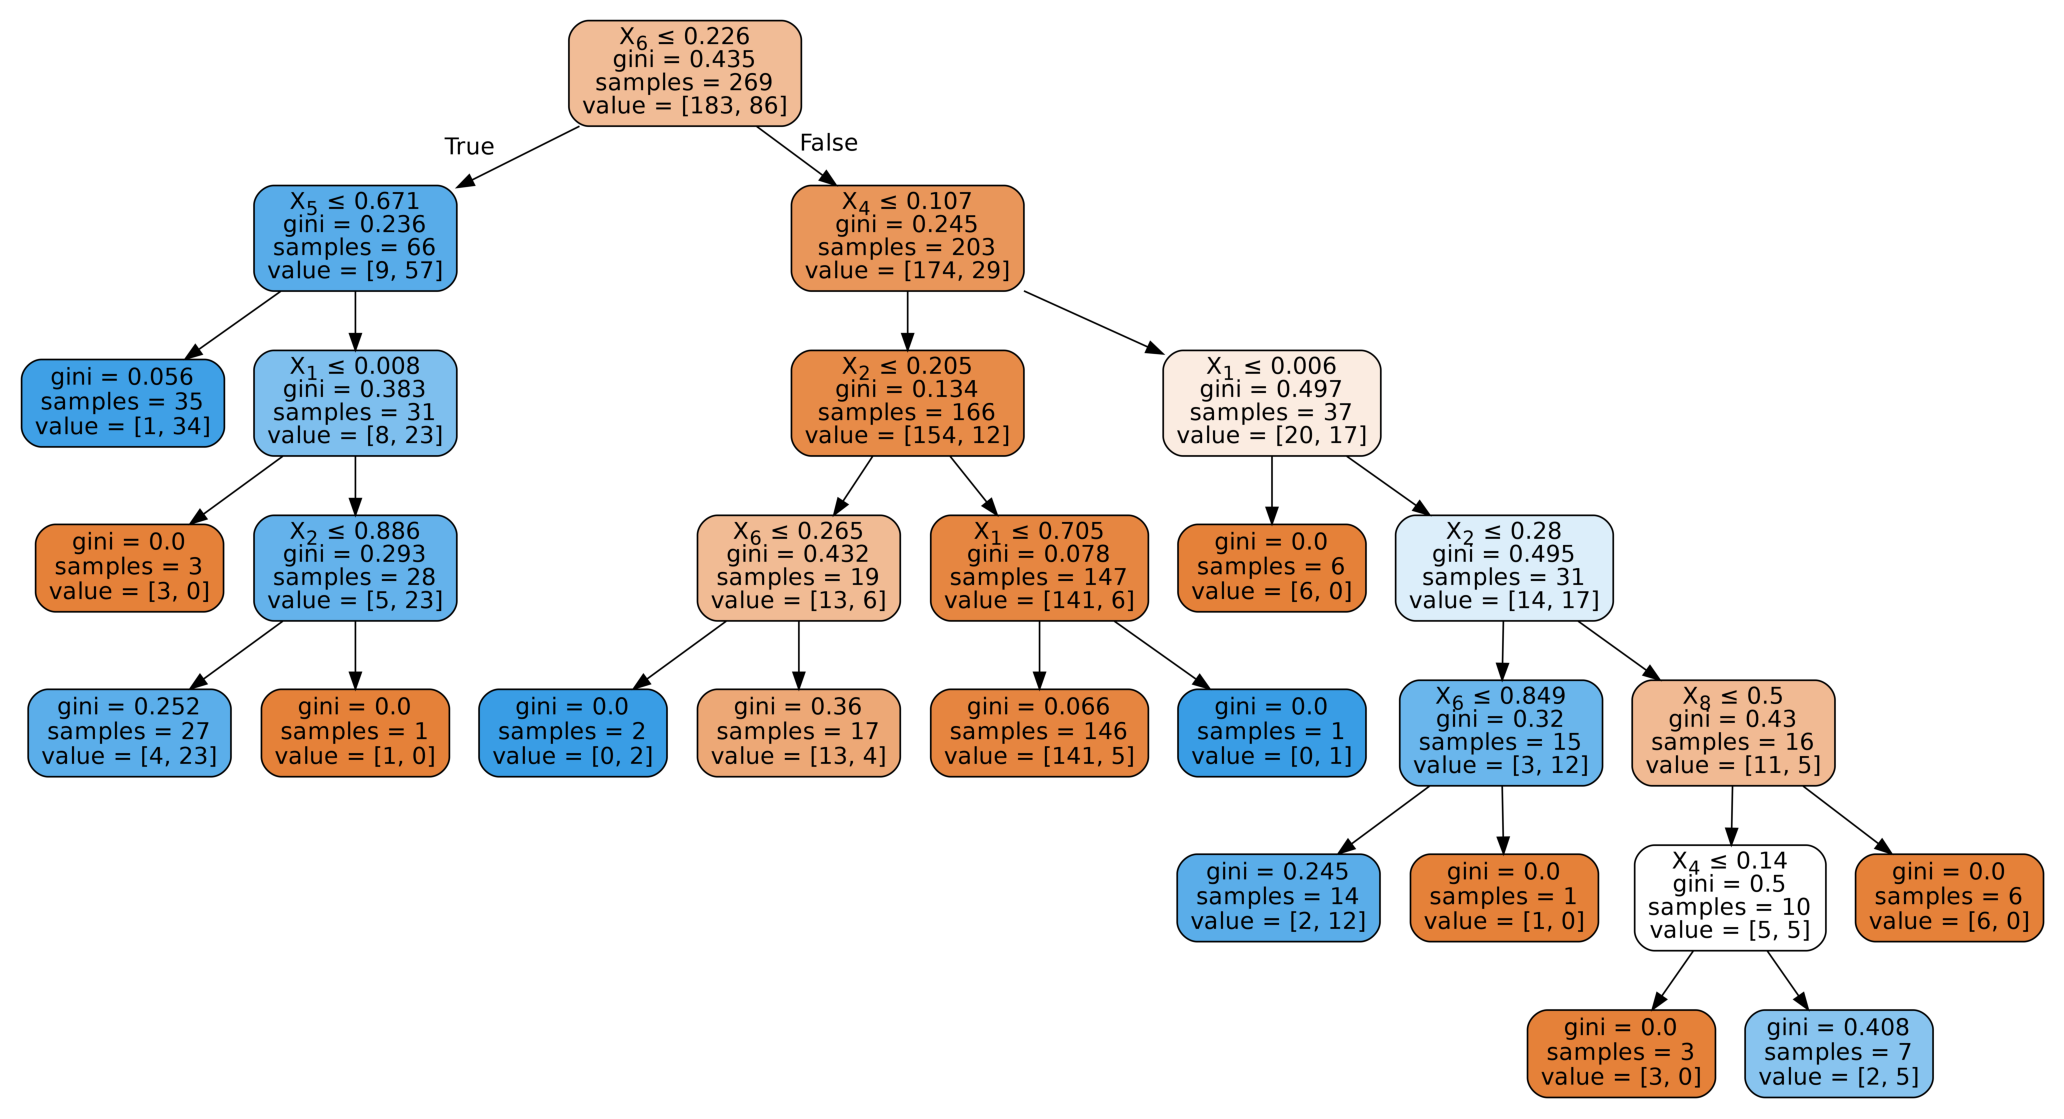

Split 2


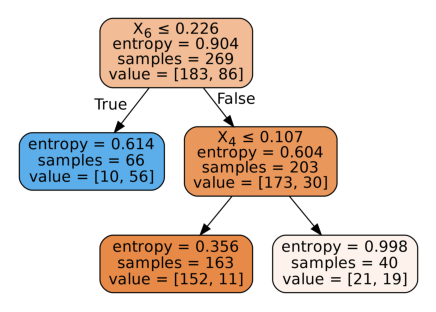

Split 3


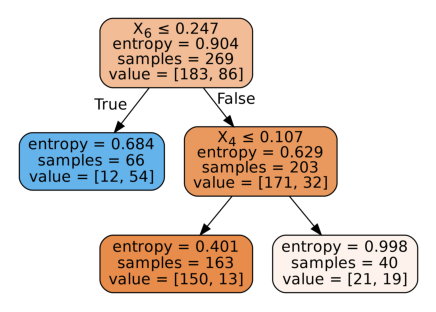

Split 4


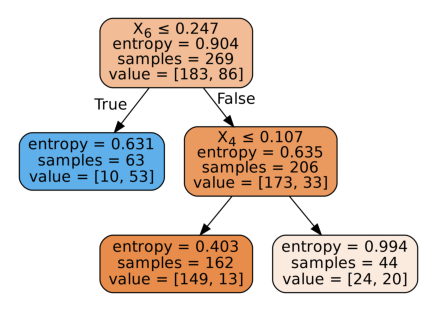

Split 5


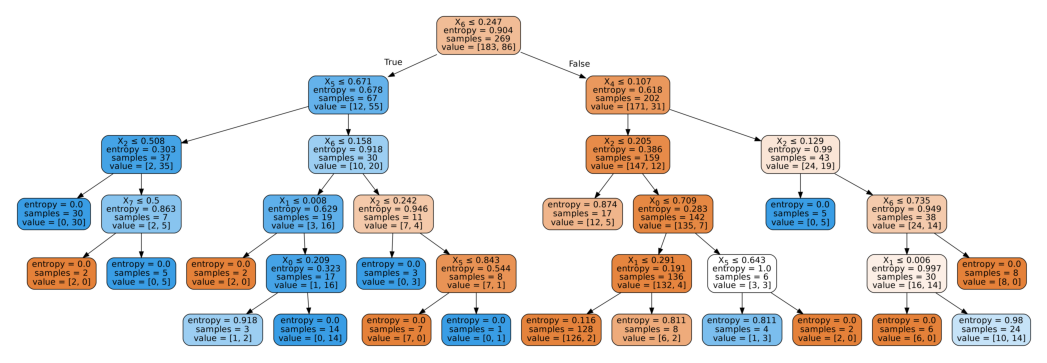

Split 6


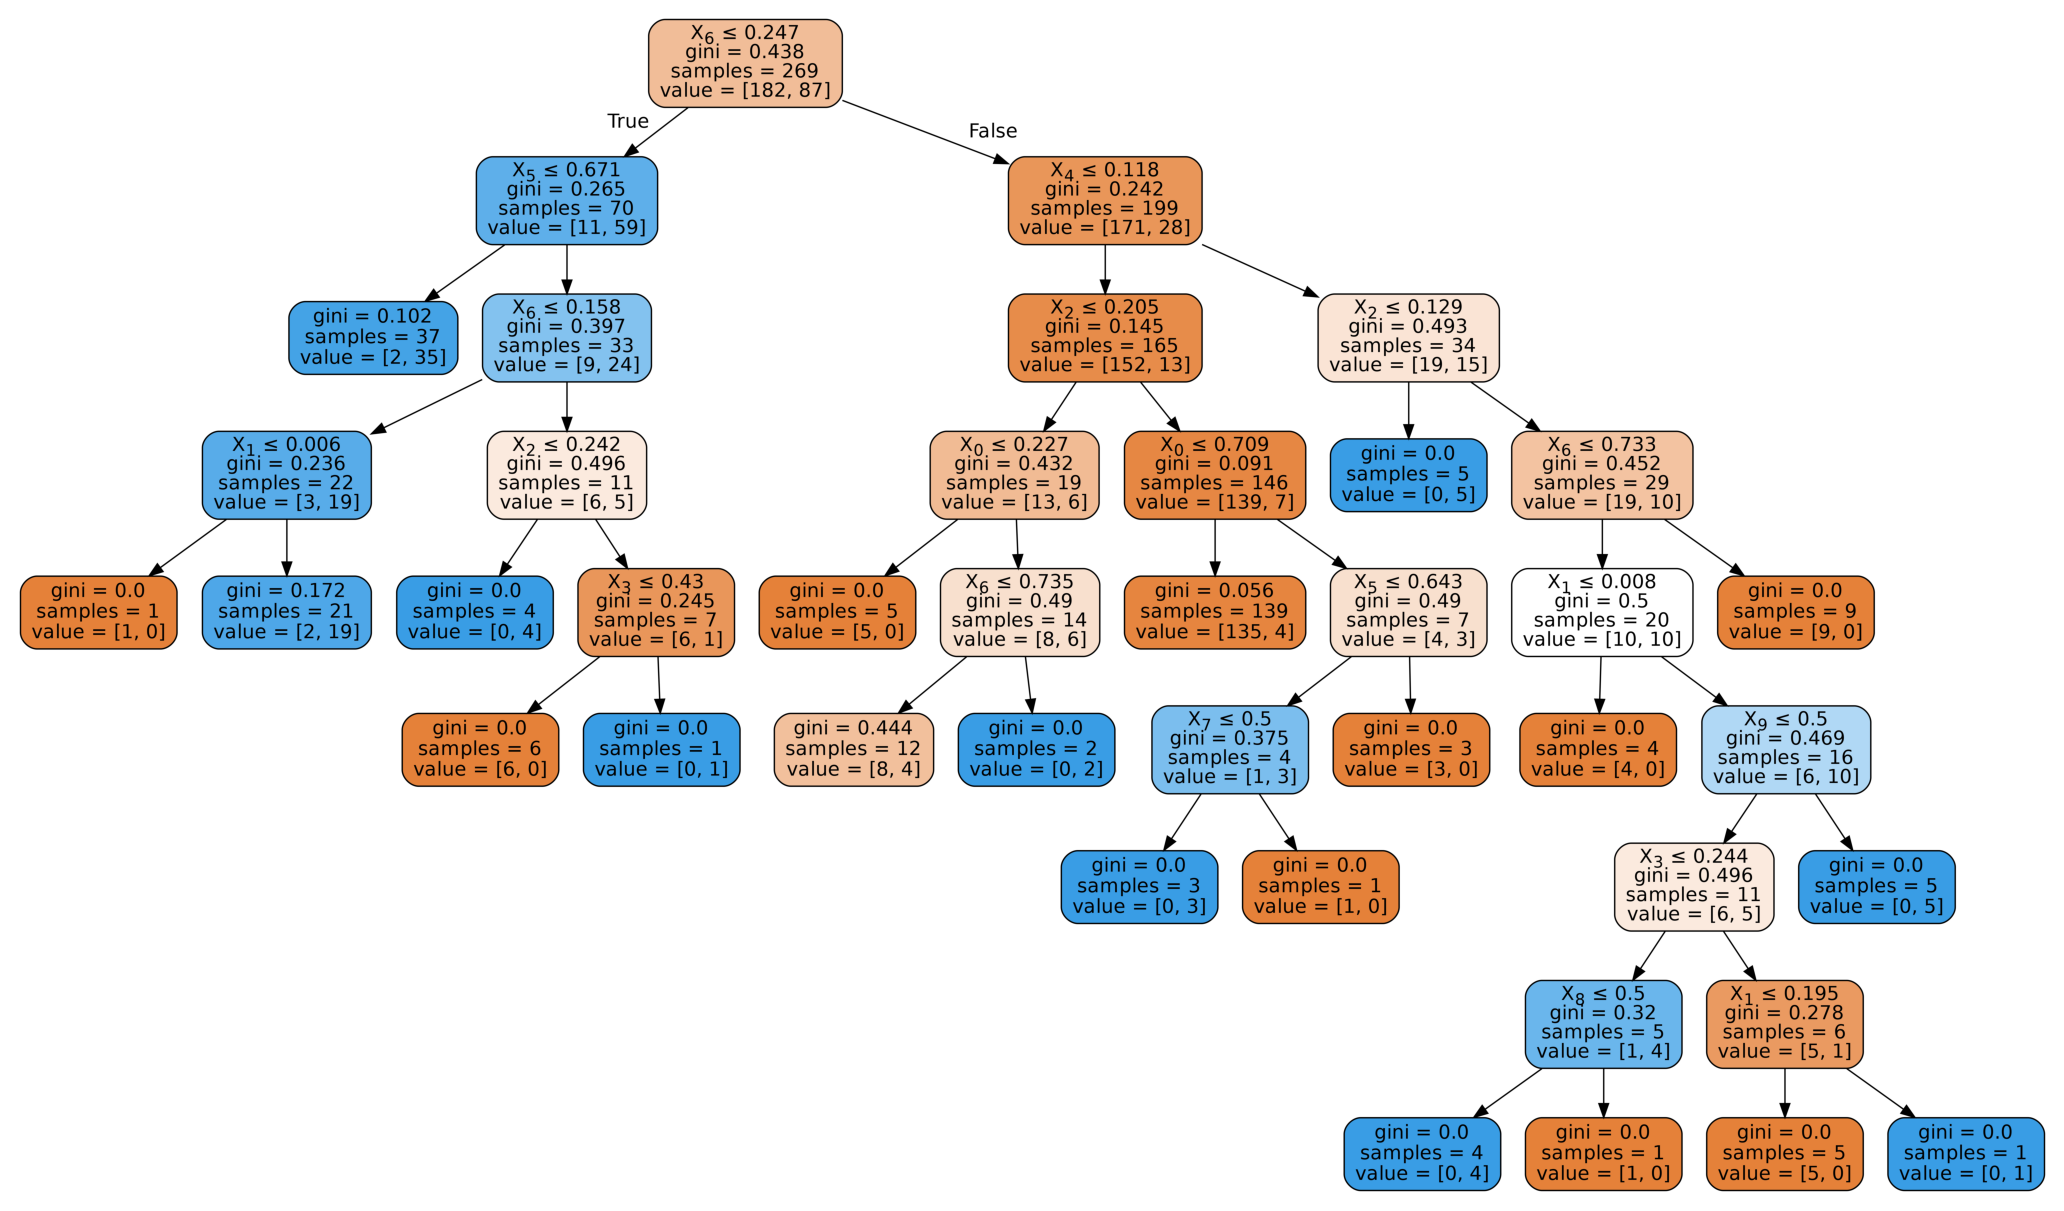

Split 7


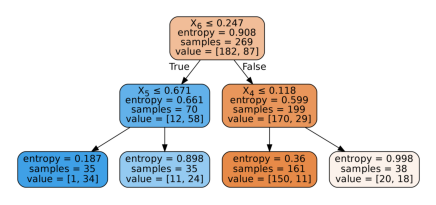

Split 8


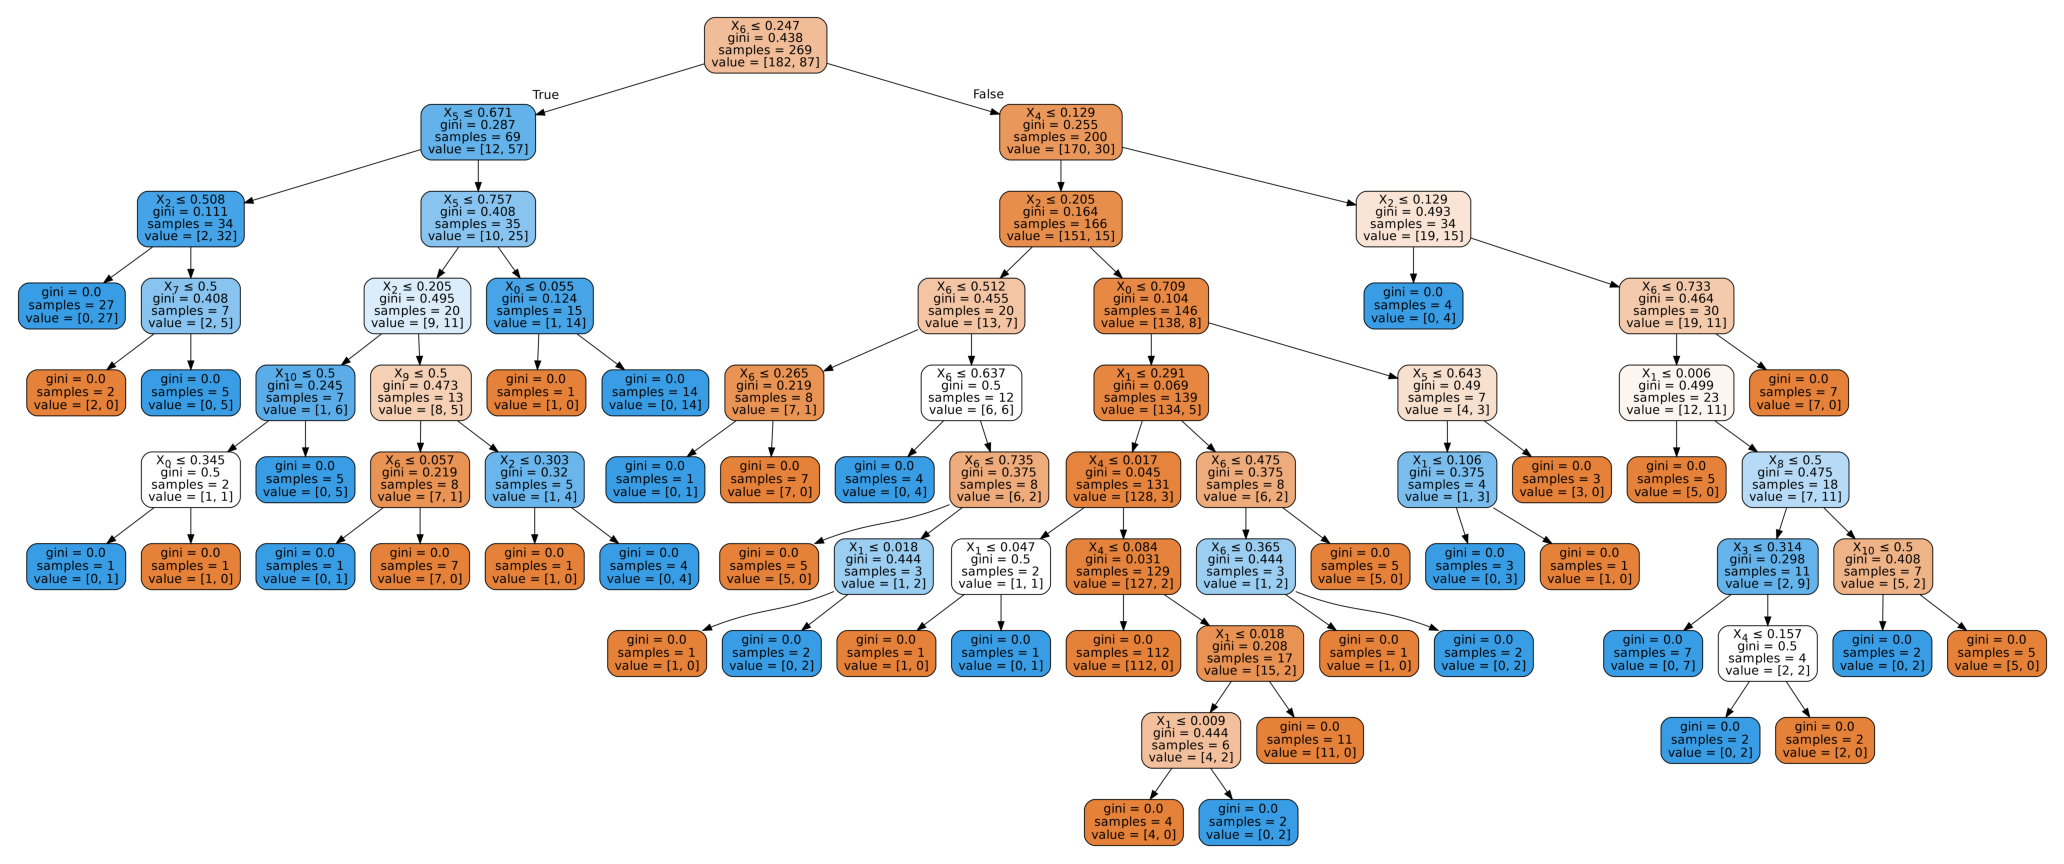

Split 9


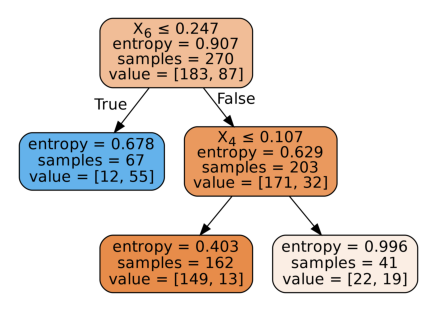

In [13]:
from sklearn.tree import export_graphviz

for i in range(NUM_SPLITS):
    print("Split %d" % i)
    dot_data = export_graphviz(split_best_tree[i], out_file=('dtree%d.dot' % i) , filled=True, rounded=True, special_characters=True)
    # Convert to png
    from subprocess import call
    call(['dot', '-Tpng', 'dtree%d.dot' % i, '-o', 'dtree%d.png' % i, '-Gdpi=600'])

    plt.figure(figsize = (1.75 * split_best[i][1], 2.25 * split_best[i][1]))
    plt.imshow(plt.imread('dtree%d.png' % i))
    plt.axis('off')
    plt.show()

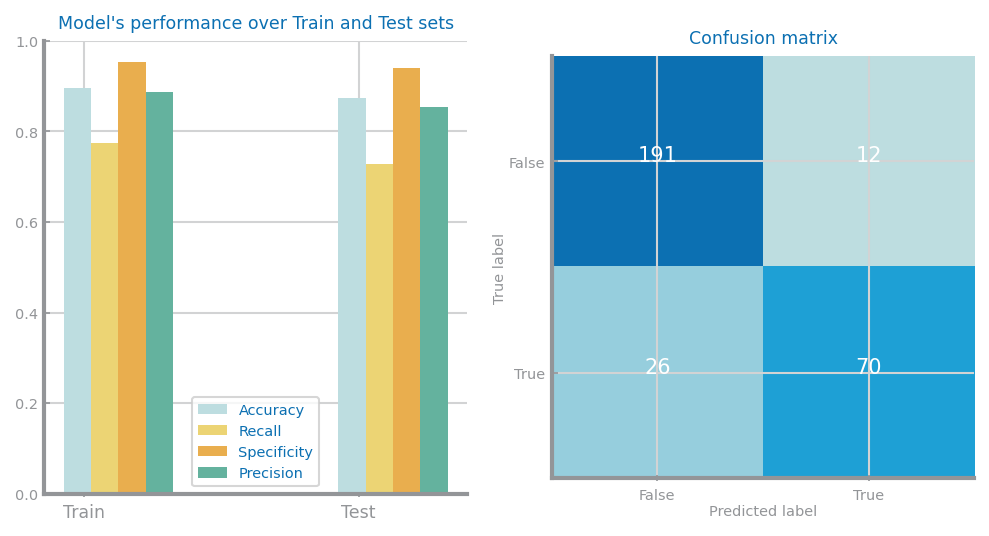

In [14]:
y_train_all = []
prd_train_all = []
y_test_all = []
prd_test_all = []

for i in range(NUM_SPLITS):
    y_train_all.extend(splits[i]['y_train'])
    prd_train_all.extend(split_best_tree[i].predict(splits[i]['X_train']))
    y_test_all.extend(splits[i]['y_test'])
    prd_test_all.extend(split_best_tree[i].predict(splits[i]['X_test']))
    
ds.plot_evaluation_results(labels, y_train_all, prd_train_all, y_test_all, prd_test_all, showXTickLabels=True)

<Figure size 600x450 with 0 Axes>

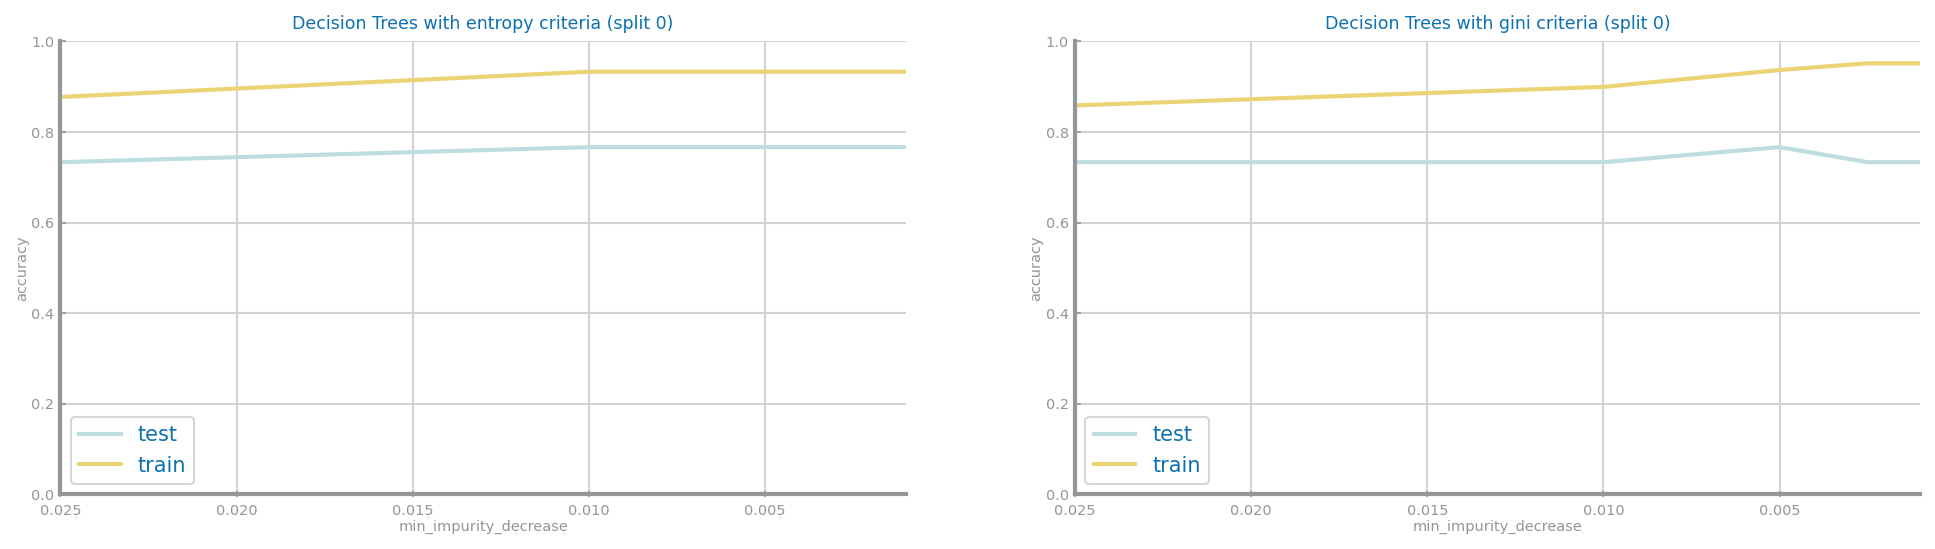

<Figure size 600x450 with 0 Axes>

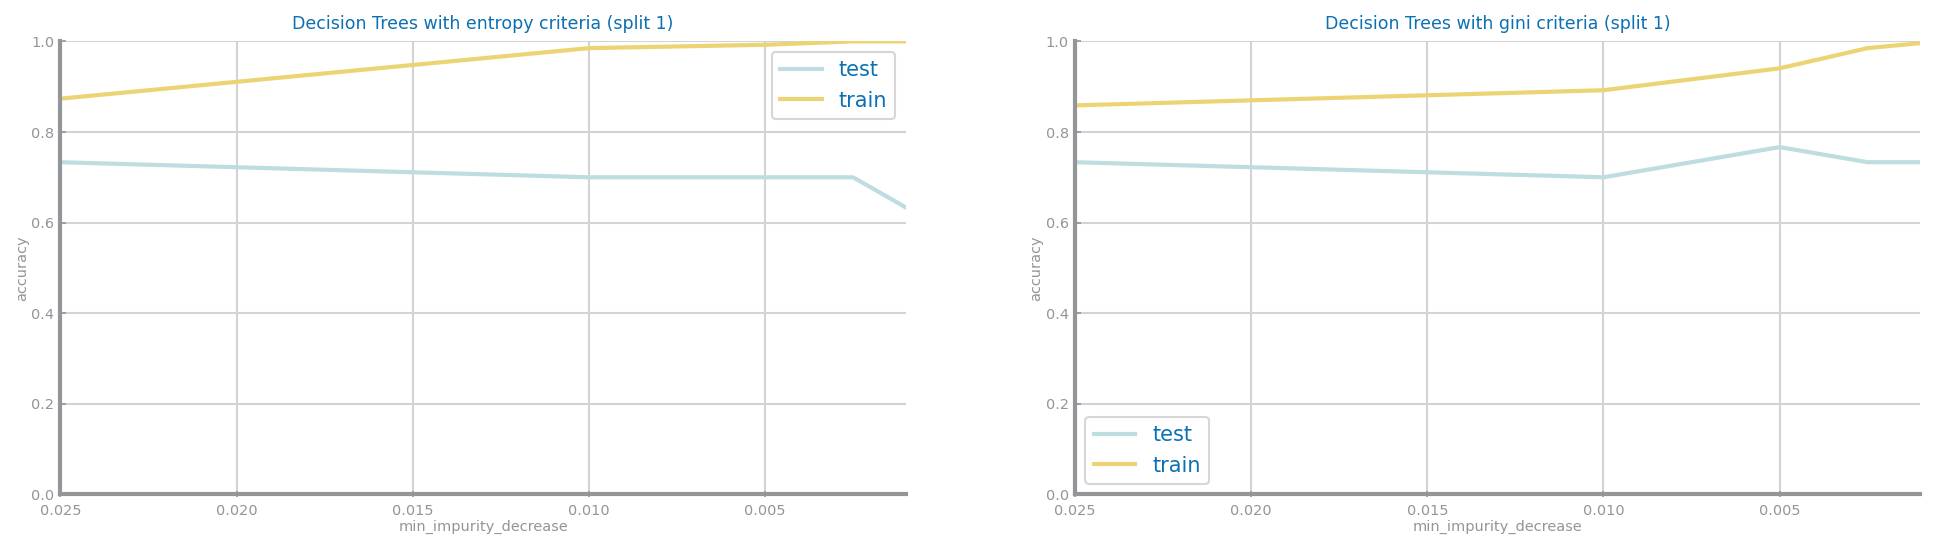

<Figure size 600x450 with 0 Axes>

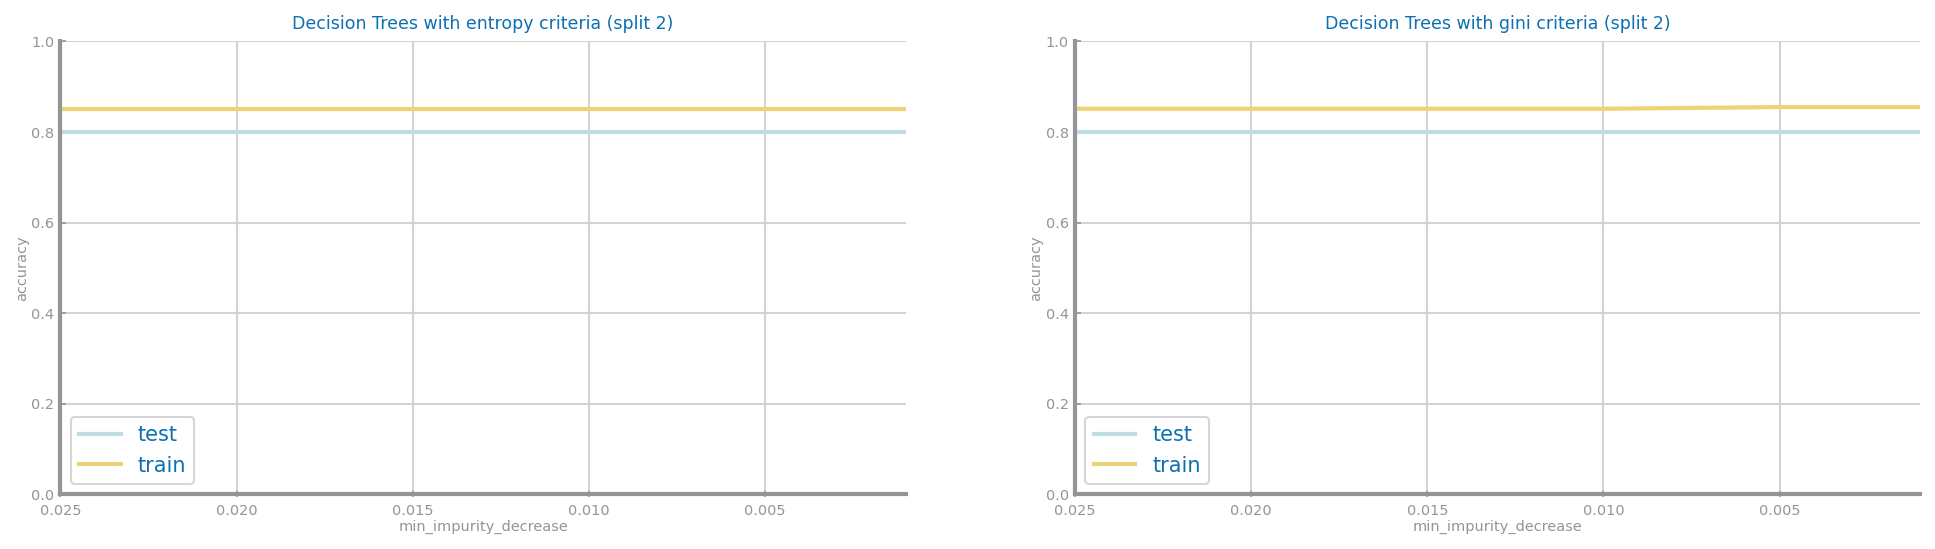

<Figure size 600x450 with 0 Axes>

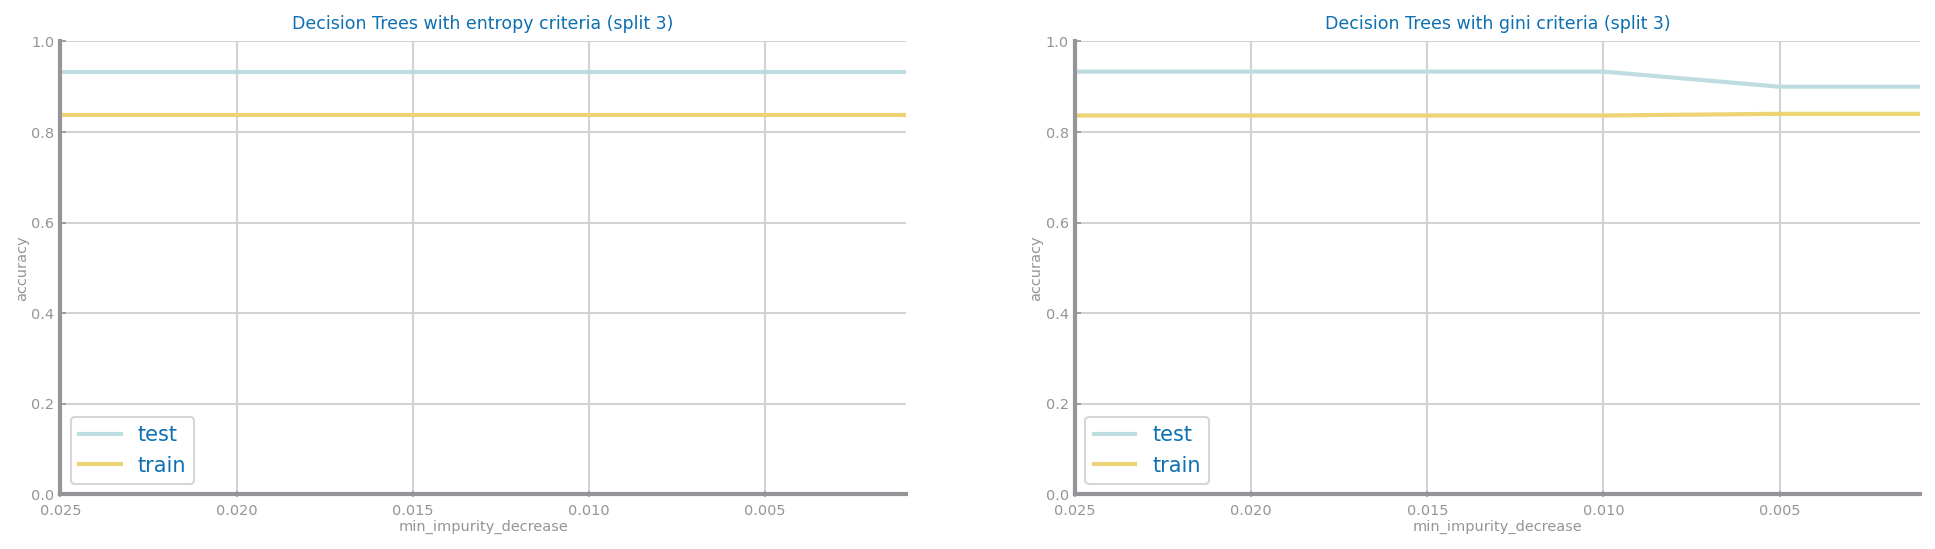

<Figure size 600x450 with 0 Axes>

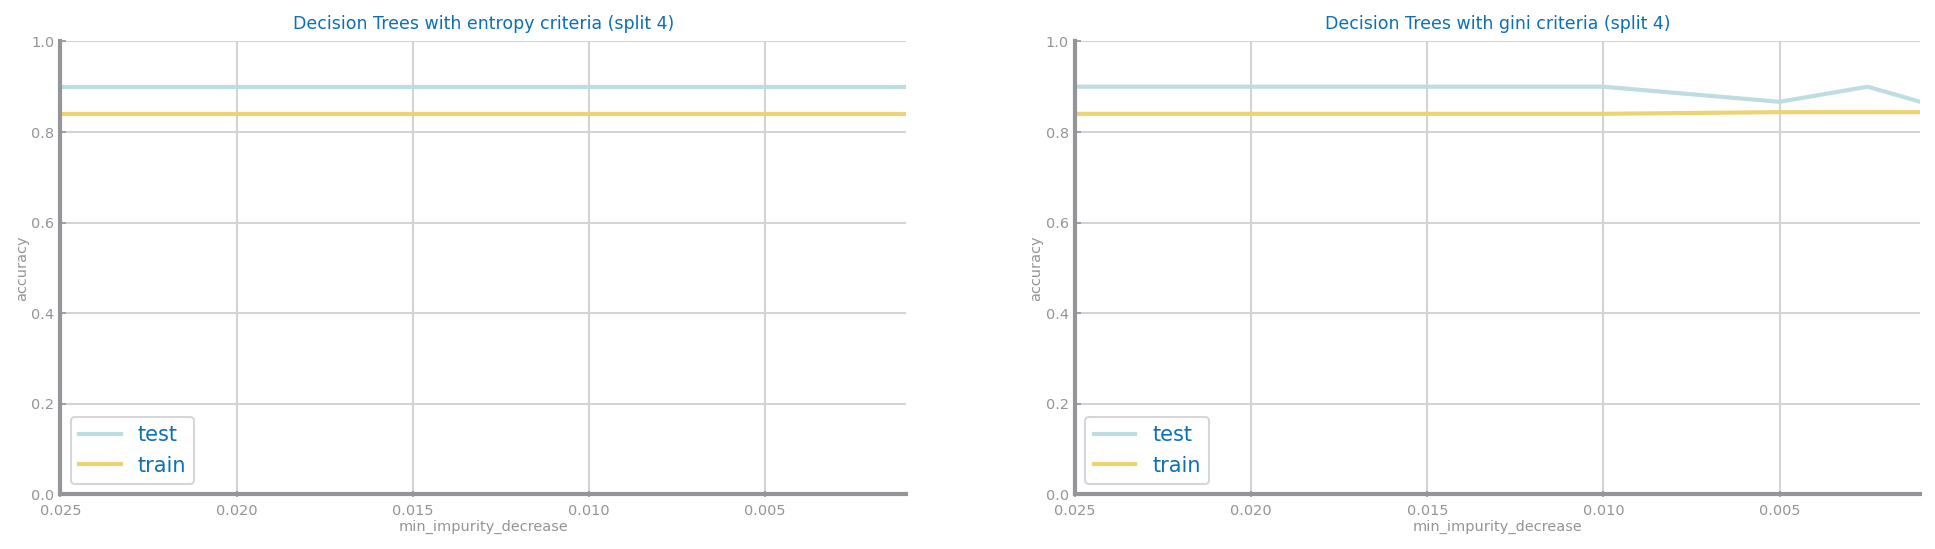

<Figure size 600x450 with 0 Axes>

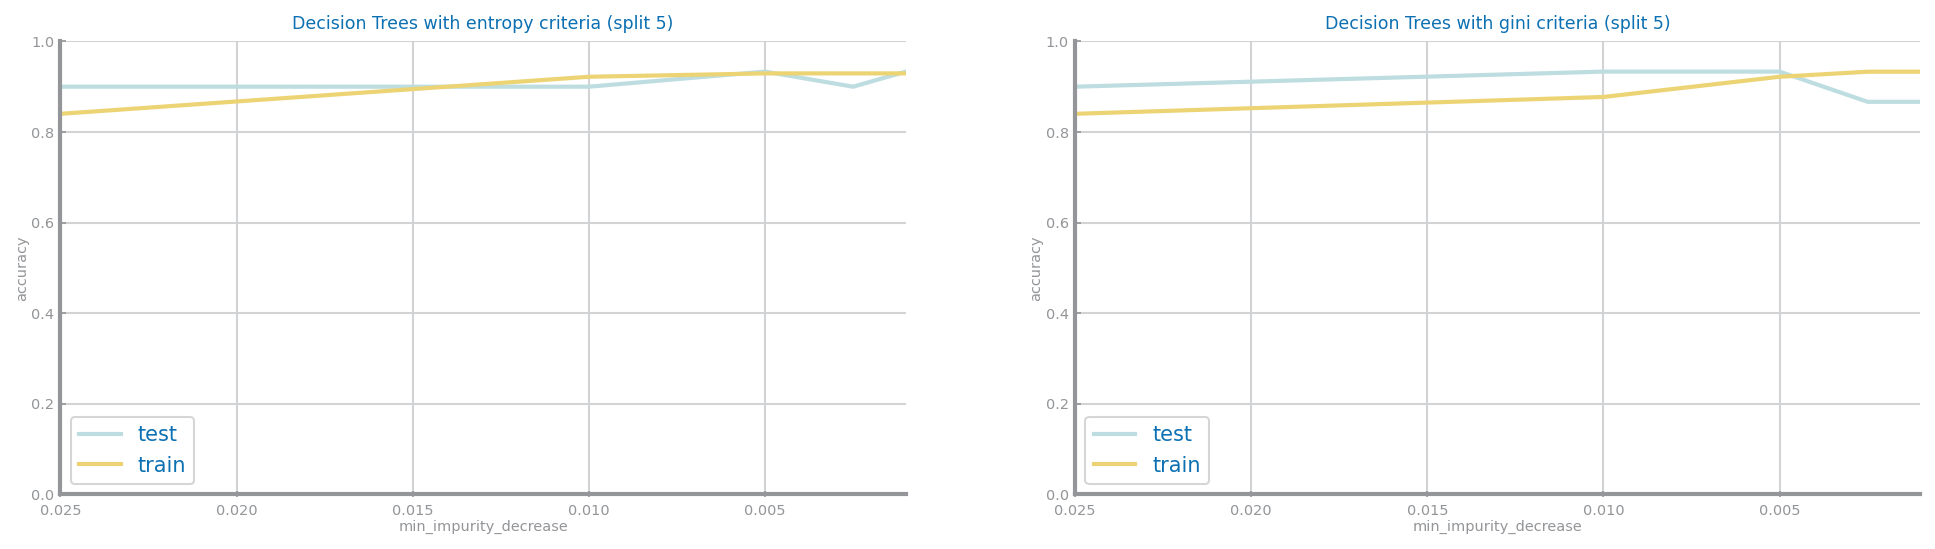

<Figure size 600x450 with 0 Axes>

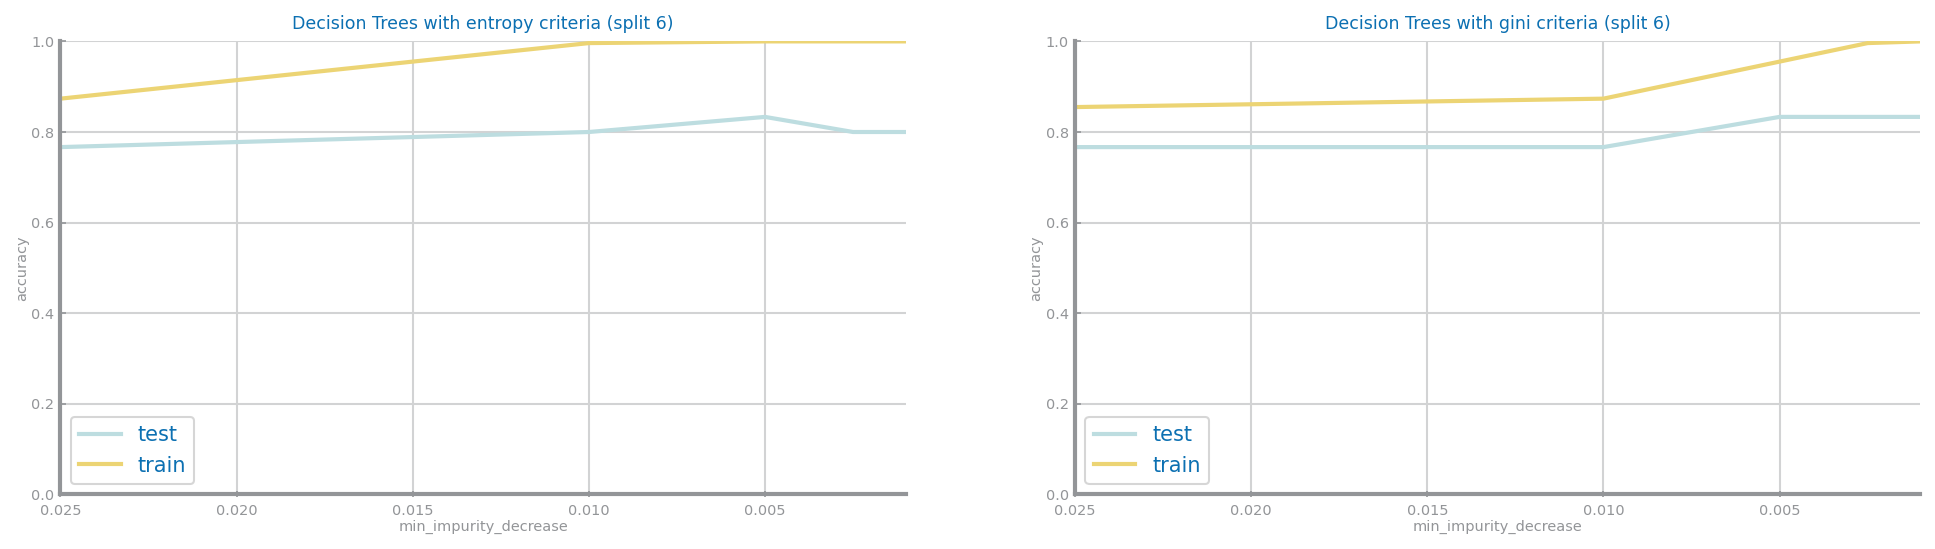

<Figure size 600x450 with 0 Axes>

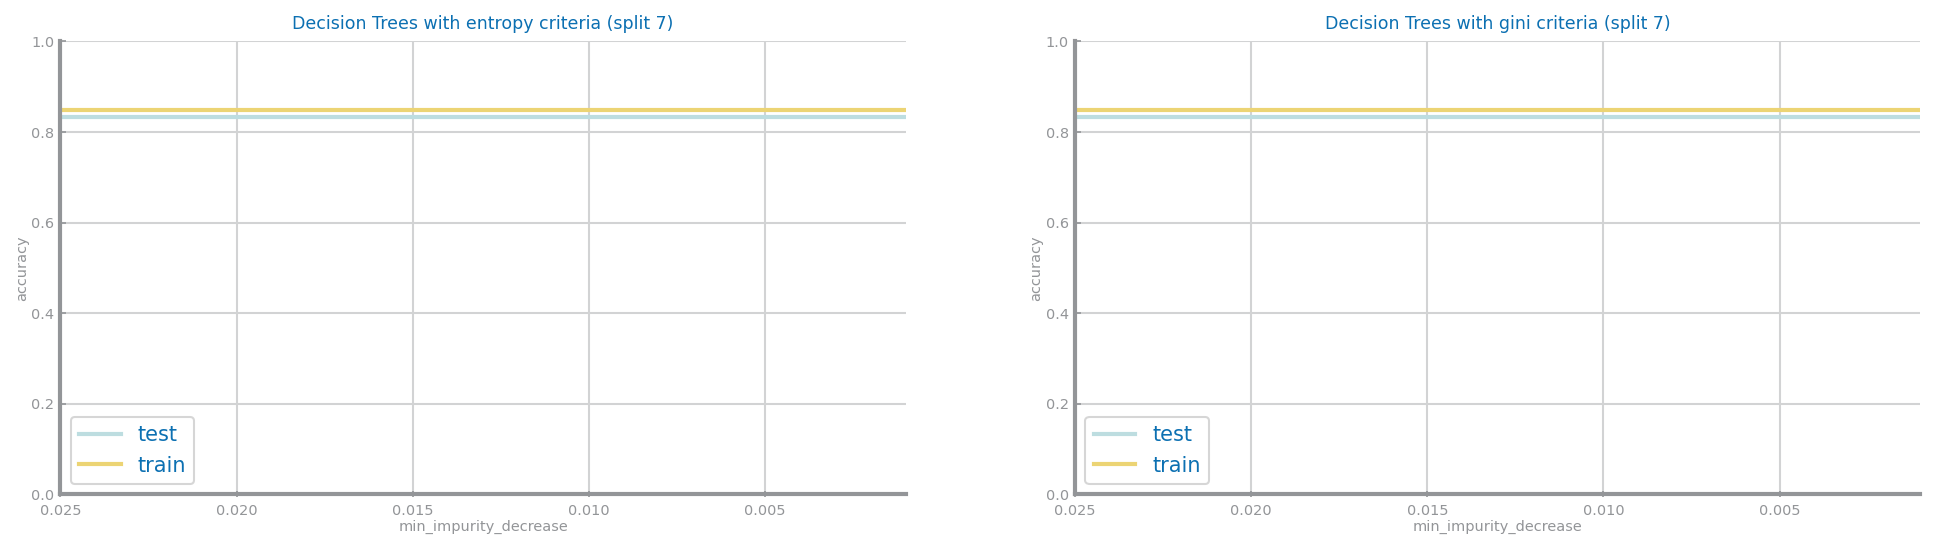

<Figure size 600x450 with 0 Axes>

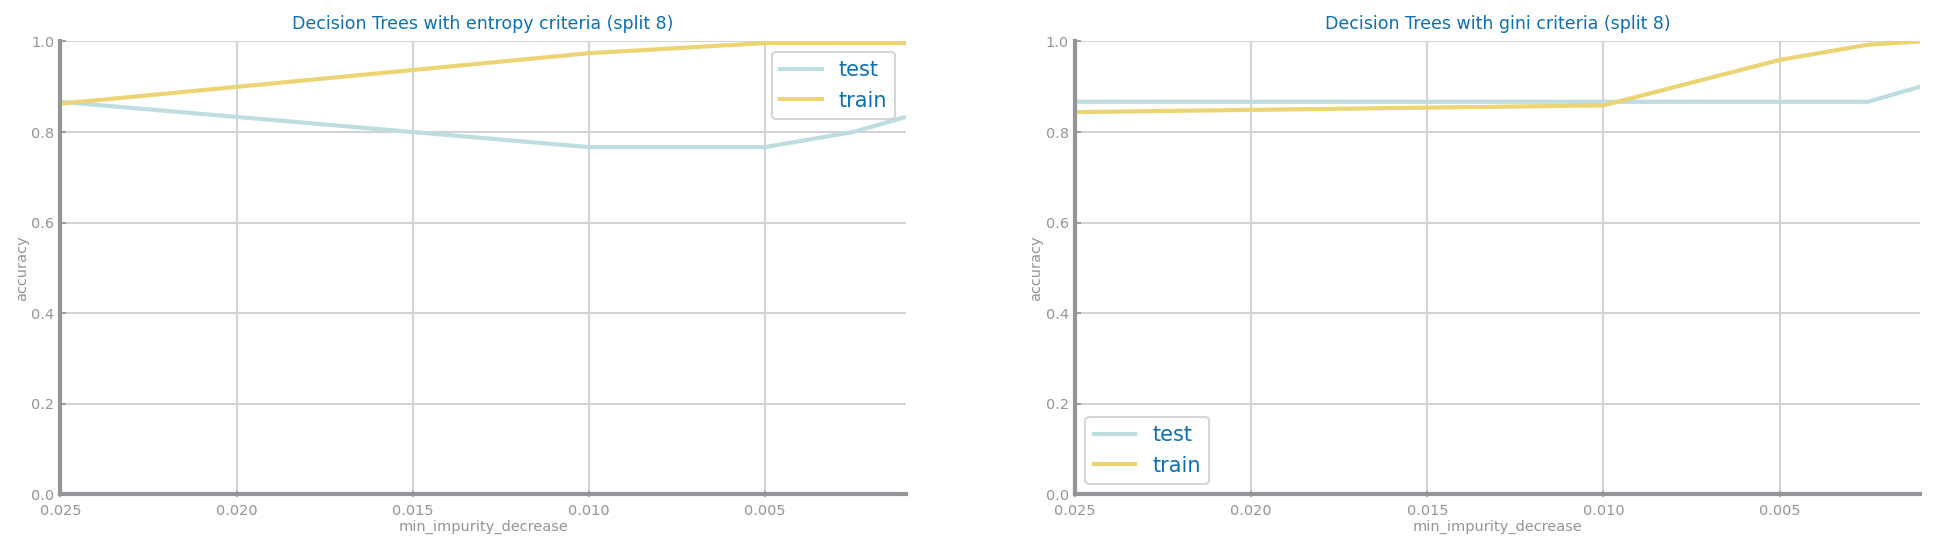

<Figure size 600x450 with 0 Axes>

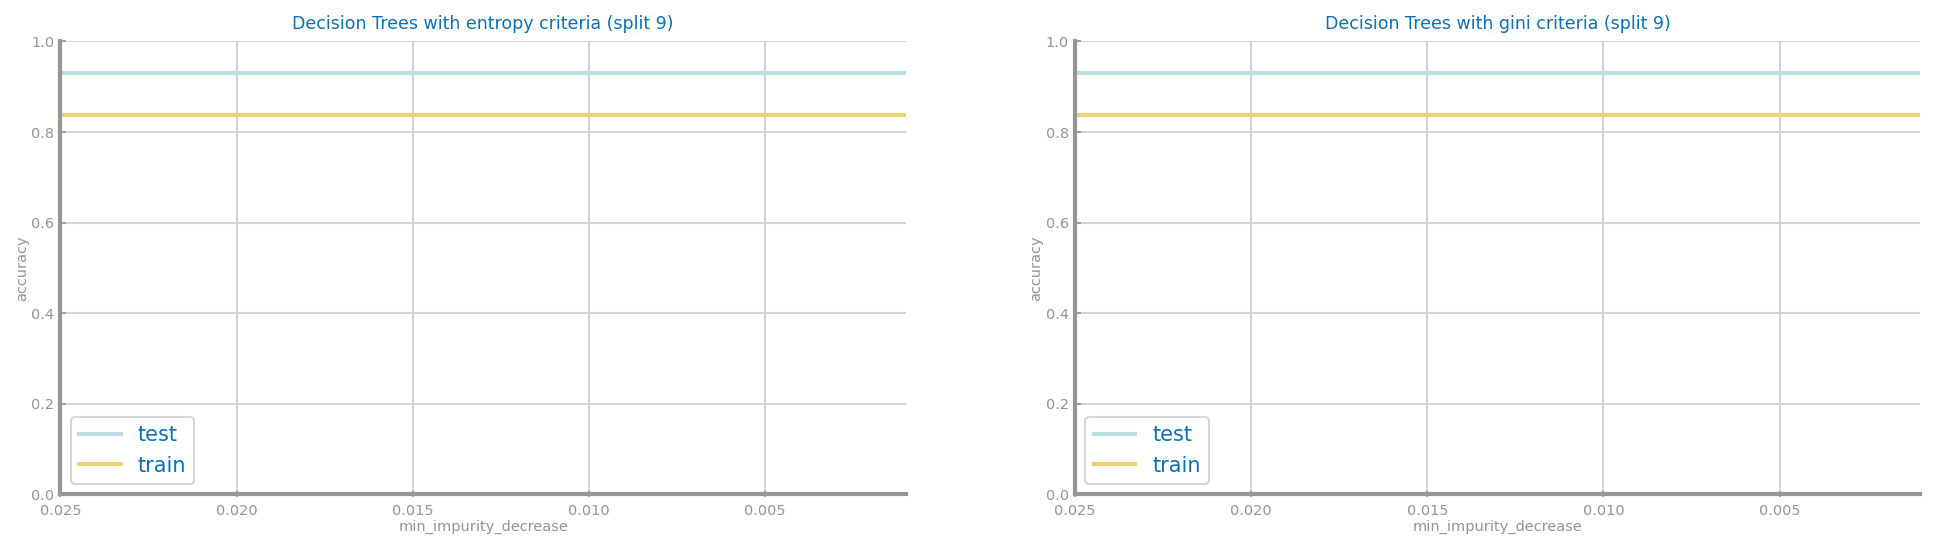

In [15]:
for i in range(NUM_SPLITS):
    d = split_best[i][1]
    plt.figure()
    fig, axs = plt.subplots(1, 2, figsize=(16, 4), squeeze=False)
    for k in range(len(criteria)):
        f = criteria[k]
        values = {}
        yvalues = []
        yvalues_train = []
        for imp in min_impurity_decrease:
            tree = DecisionTreeClassifier(max_depth=d, criterion=f, min_impurity_decrease=imp)
            tree.fit(splits[i]['X_train'], splits[i]['y_train'])
            prdY = tree.predict(splits[i]['X_test'])
            prdY_train = tree.predict(splits[i]['X_train'])
            yvalues.append(metrics.accuracy_score(splits[i]['y_test'], prdY))
            yvalues_train.append(metrics.accuracy_score(splits[i]['y_train'], prdY_train))
        values['test'] = yvalues
        values['train'] = yvalues_train
        ds.multiple_line_chart(min_impurity_decrease, values, ax=axs[0, k], title='Decision Trees with %s criteria (split %d)'%(f, i),
                           xlabel='min_impurity_decrease', ylabel='accuracy', percentage=True)

    plt.show()

### Summary
---

- ***How do models improve with the increase of max_depth?***

Overall, they tend to decrease accuracy. 2 seems to be the most consistent best value for depth, even though 5 and 10 were the best depths for some splits

- ***How does performance change with decrease of min_impurity_decrease?***

Performance decreases with the decrease of min_impurity_decrease for all depths except 2 that stays the same.

- ***How do different criteria impact the model performance?***

Entropy achieves the best results when dealing with higher min_impurity_decrease but as we decrease it, gini performance decreases slower than entropy's.

- ***What is the best parametrisation (criteria, max_depth and min_impurity_decrease)?***

Best results achieved in split 0 with entropy criteria, depth=2 and min_impurity_decrease=0.025000 ==> accuracy=0.900000

- ***Is the accuracy achieved good enough?***

Yes, althought there might be overfitting.

- ***What is the largest kind of errors?***

Most of the times there are no errors, but when there are is always one false negative.

- ***Is it possible to identify overfitting?***

Most of the times **no**, test accuracy is better than train accuracy, even when we decrease min_impurity_decrease (when using the best depth).

## 3.4. Random Forests
---

<Figure size 600x450 with 0 Axes>

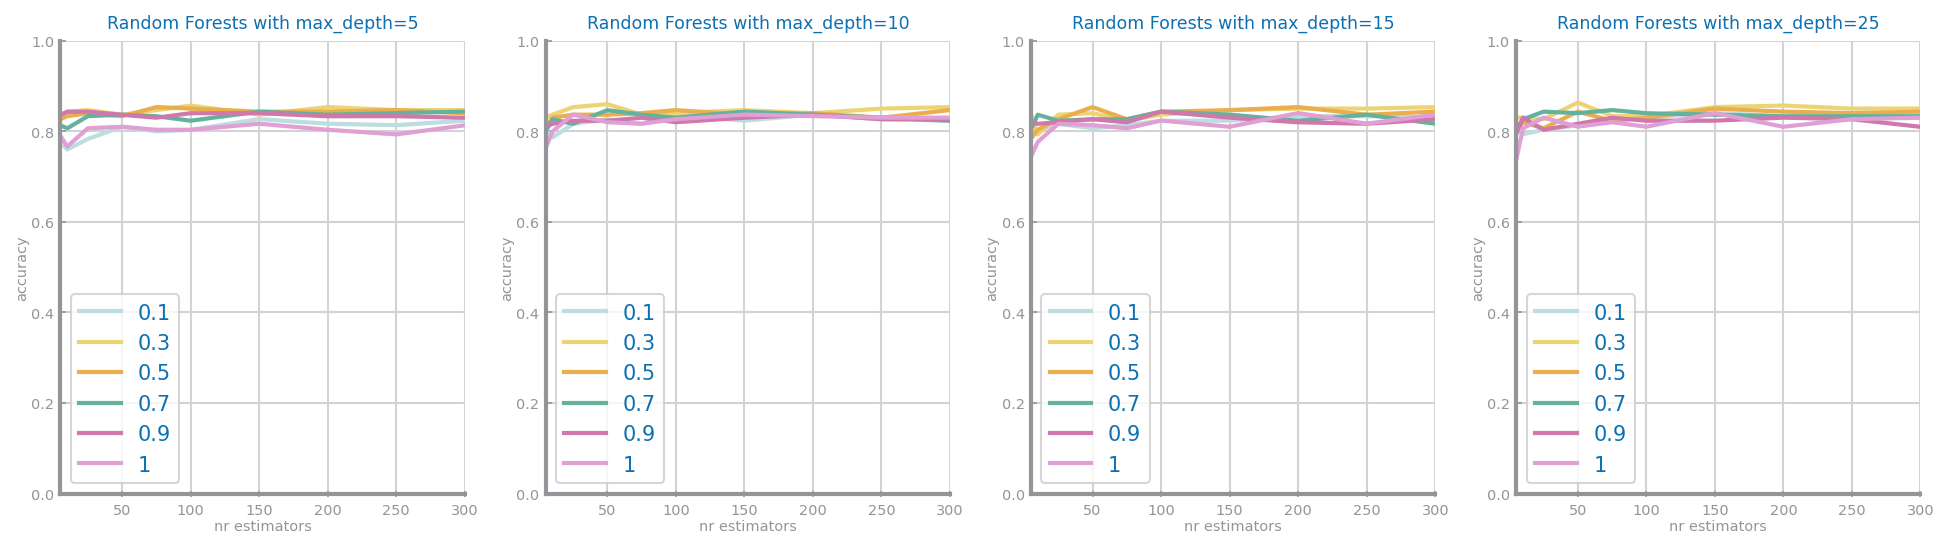

Best results with depth=15, 1.000000 features and 100 estimators, with accuracy=1.000000
Best results per split:
	Split 0: depth=25 , 0.100000 features and 5 estimators ==> accuracy=0.866667
	Split 1: depth=15 , 0.900000 features and 5 estimators ==> accuracy=0.833333
	Split 2: depth=5 , 0.300000 features and 10 estimators ==> accuracy=0.866667
	Split 3: depth=5 , 0.100000 features and 5 estimators ==> accuracy=0.966667
	Split 4: depth=10 , 0.300000 features and 25 estimators ==> accuracy=0.933333
	Split 5: depth=5 , 0.900000 features and 25 estimators ==> accuracy=0.933333
	Split 6: depth=5 , 0.100000 features and 50 estimators ==> accuracy=0.866667
	Split 7: depth=5 , 0.100000 features and 75 estimators ==> accuracy=0.900000
	Split 8: depth=25 , 0.900000 features and 10 estimators ==> accuracy=0.966667
	Split 9: depth=15 , 1.000000 features and 100 estimators ==> accuracy=1.000000


In [16]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]
max_depths = [5, 10, 15, 25]
max_features = [.1, .3, .5, .7, .9, 1]
best = ('', 0, 0)  
last_best = 0
best_forest = None
best_split = None
best_spli = 0

NUM_SPLITS = len(splits)
split_best = [('',  0, 0.0)] * NUM_SPLITS
split_best_forest = [None] * NUM_SPLITS
split_last_best = [0] * NUM_SPLITS

cols = len(max_depths)

plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)

for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    for f in max_features:
        values[f] = []
        for i in range(len(n_estimators)):
            values[f].append(0)
    for spli in range(NUM_SPLITS):
        split = splits[spli]
        for f in max_features:
            yvalues = []
            for n in n_estimators:
                rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
                rf.fit(split['X_train'], split['y_train'])
                split['prdY'] = rf.predict(split['X_test'])
                yvalues.append(metrics.accuracy_score(split['y_test'], split['prdY']))
                                               
                # Check if accuracy is better than best overall
                if yvalues[-1] > last_best:
                    best = (d, f, n)
                    last_best = yvalues[-1]
                    best_forest = rf
                    best_split = split
                    best_spli = spli
                                               
                # Check if accuracy is better than best in current split
                if yvalues[-1] > split_last_best[spli]:
                    split_best[spli] = (d, f, n)
                    split_last_best[spli] = yvalues[-1]
                    split_best_forest[spli] = rf
                                               
            # Increment total accuracy for current (max_depth, min_impurity decrease)
            for i in range(len(yvalues)):
                values[f][i] += yvalues[i]
    # Normalize
    for v in values:
        for i in range(len(values[v])):
            values[v][i] /= NUM_SPLITS
            
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Random Forests with max_depth=%d'%d,
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)
plt.show()
print('Best results with depth=%d, %f features and %d estimators, with accuracy=%f'%(best[0], best[1], best[2], last_best))

print('Best results per split:')
for i in range(len(splits)):
    print('\tSplit %d: depth=%d , %f features and %d estimators ==> accuracy=%f' % (i, *split_best[i], split_last_best[i]))

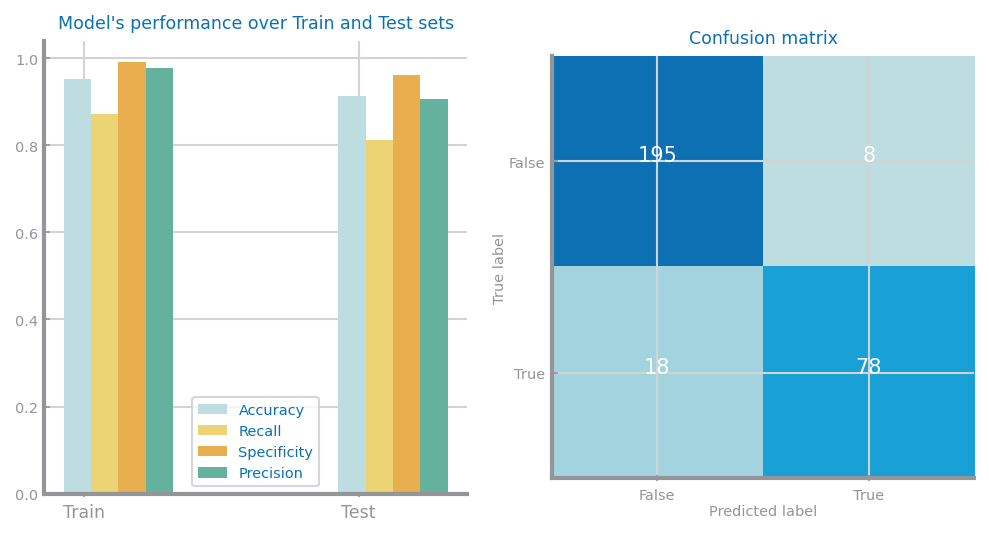

In [17]:
y_train_all = []
prd_train_all = []
y_test_all = []
prd_test_all = []

for i in range(NUM_SPLITS):
    y_train_all.extend(splits[i]['y_train'])
    prd_train_all.extend(split_best_forest[i].predict(splits[i]['X_train']))
    y_test_all.extend(splits[i]['y_test'])
    prd_test_all.extend(split_best_forest[i].predict(splits[i]['X_test']))

ds.plot_evaluation_results(labels, y_train_all, prd_train_all, y_test_all, prd_test_all, showXTickLabels=True)